In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd

In [2]:
import models
import class_sampling
import train
import metric_utils
import inference

In [3]:
NUM_CLASSES = 10
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
momentum = 0



random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

NUM_CLASSES_REDUCED = 2
nums = (0, 1)
ratio = (100, 1)
#nums = (0, 3, 1)
#ratio = (200, 20, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}

DIRECTORY = f"results/CIFAR10_logistic_regression"


simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.Ratio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
targets = ratio_train_CIFAR10.labels

class_count = np.unique(targets, return_counts=True)[1]

# try undersampling 

weight = 1. / class_count
samples_weight = weight[targets]
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

weight *= min(class_count)

In [6]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True)  

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

train_loader_oversampled = DataLoader(ratio_train_CIFAR10, batch_size=batch_size_train, sampler=sampler)

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True)

In [23]:
# SIGMOID 2 CLASS 

momentum=0
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(2, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/reduced{i}/model{epoch}"
            directory=None
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False, directory=directory)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 2 Classes with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   

ValueError: Target size (torch.Size([1000])) must be the same as input size (torch.Size([1000, 3]))


Test set: Avg. loss: 0.016227169036865233, AUC: 0.444699


Test set: Avg. loss: 0.09092181142171224, AUC: 0.679864


Test set: Avg. loss: 0.23298455810546875, AUC: 0.621


Test set: Avg. loss: 1.4865523681640624, AUC: 0.5


Test set: Avg. loss: 0.7308057657877605, AUC: 0.50475


Test set: Avg. loss: 0.5547076009114583, AUC: 0.531


Test set: Avg. loss: 0.6885259195963541, AUC: 0.5344315


Test set: Avg. loss: 1.0203351847330728, AUC: 0.5025


Test set: Avg. loss: 0.13155865478515624, AUC: 0.7217707499999999


Test set: Avg. loss: 2.608717692057292, AUC: 0.5


Test set: Avg. loss: 0.3523627726236979, AUC: 0.6030000000000001


Test set: Avg. loss: 0.23448631286621094, AUC: 0.6567092499999999


Test set: Avg. loss: 1.1552028401692709, AUC: 0.50075


Test set: Avg. loss: 0.5808262532552083, AUC: 0.5310037499999999


Test set: Avg. loss: 0.17213704935709637, AUC: 0.6699999999999999


Test set: Avg. loss: 2.0159017333984375, AUC: 0.5


Test set: Avg. loss: 0.28271685791015627, AUC: 0.60775



Test set: Avg. loss: 1.8506775716145833, AUC: 0.5


Test set: Avg. loss: 0.8751944783528646, AUC: 0.5090089999999999


Test set: Avg. loss: 0.25858399454752606, AUC: 0.6620409999999999


Test set: Avg. loss: 0.31809398396809896, AUC: 0.613385


Test set: Avg. loss: 3.1694443359375, AUC: 0.5


Test set: Avg. loss: 0.04637271499633789, AUC: 0.55185525


Test set: Avg. loss: 1.3552244466145833, AUC: 0.50075


Test set: Avg. loss: 1.7786507161458334, AUC: 0.5


Test set: Avg. loss: 0.9642835083007812, AUC: 0.5005000000000001


Test set: Avg. loss: 0.9737610880533855, AUC: 0.50175


Test set: Avg. loss: 0.21366697692871095, AUC: 0.63325


Test set: Avg. loss: 0.08768159739176433, AUC: 0.6739999999999999


Test set: Avg. loss: 0.9644857381184896, AUC: 0.5049999999999999


Test set: Avg. loss: 0.27808113606770835, AUC: 0.513


Test set: Avg. loss: 0.6480243937174479, AUC: 0.52772325


Test set: Avg. loss: 0.4202890319824219, AUC: 0.592


Test set: Avg. loss: 0.7260981648763021, AUC: 0.508502

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 1.0202772623697918, AUC: 0.50275



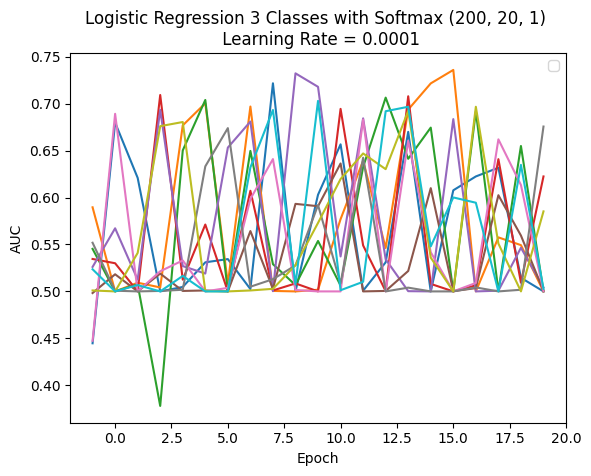


Test set: Avg. loss: 0.019741334279378256, AUC: 0.5325395


Test set: Avg. loss: 0.04372762680053711, AUC: 0.5980502500000001


Test set: Avg. loss: 0.011971995353698731, AUC: 0.6305425


Test set: Avg. loss: 0.46411478678385415, AUC: 0.5


Test set: Avg. loss: 0.035805089314778646, AUC: 0.6045967499999999


Test set: Avg. loss: 0.012758169174194336, AUC: 0.7010660000000001


Test set: Avg. loss: 0.06877403259277344, AUC: 0.5260165


Test set: Avg. loss: 0.03614052200317383, AUC: 0.5873727500000001


Test set: Avg. loss: 0.12435099792480468, AUC: 0.502


Test set: Avg. loss: 0.08754593658447266, AUC: 0.51176


Test set: Avg. loss: 0.14886384582519532, AUC: 0.5005


Test set: Avg. loss: 0.06160284550984701, AUC: 0.5232587500000001


Test set: Avg. loss: 0.25417562357584633, AUC: 0.5


Test set: Avg. loss: 0.1047155024210612, AUC: 0.50325


Test set: Avg. loss: 0.01998012351989746, AUC: 0.673004


Test set: Avg. loss: 0.011455435752868653, AUC: 0.6929695


Test set: Avg. loss: 0.0884567


Test set: Avg. loss: 0.011753372510274251, AUC: 0.67323


Test set: Avg. loss: 0.08029268646240234, AUC: 0.52000125


Test set: Avg. loss: 0.20936673482259113, AUC: 0.50025


Test set: Avg. loss: 0.09449288686116536, AUC: 0.5052515


Test set: Avg. loss: 0.03303500811258952, AUC: 0.60386675


Test set: Avg. loss: 0.025583877563476562, AUC: 0.525115


Test set: Avg. loss: 0.00930119800567627, AUC: 0.653481


Test set: Avg. loss: 0.07178161366780599, AUC: 0.513762


Test set: Avg. loss: 0.03819808832804362, AUC: 0.568004


Test set: Avg. loss: 0.11805457305908203, AUC: 0.503


Test set: Avg. loss: 0.09756714630126953, AUC: 0.513505


Test set: Avg. loss: 0.20926542663574219, AUC: 0.50025


Test set: Avg. loss: 0.2727887471516927, AUC: 0.50025


Test set: Avg. loss: 0.01998539670308431, AUC: 0.53620175


Test set: Avg. loss: 0.05534756724039713, AUC: 0.5689979999999999


Test set: Avg. loss: 0.020449036916097004, AUC: 0.583563


Test set: Avg. loss: 0.27312109375, AUC: 0.5


Test set: Av

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.1687407938639323, AUC: 0.50075



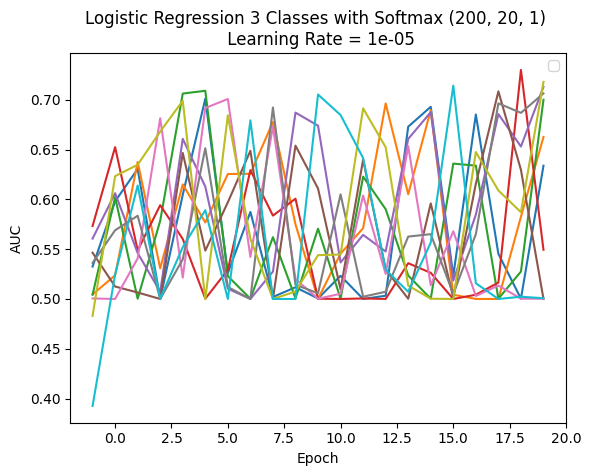


Test set: Avg. loss: 0.05859609603881836, AUC: 0.51735975


Test set: Avg. loss: 0.03463599522908529, AUC: 0.54704175


Test set: Avg. loss: 0.030891574223836264, AUC: 0.56360125


Test set: Avg. loss: 0.02424526850382487, AUC: 0.58125425


Test set: Avg. loss: 0.02781739362080892, AUC: 0.5785075000000001


Test set: Avg. loss: 0.02499803352355957, AUC: 0.5874585


Test set: Avg. loss: 0.020525792439778645, AUC: 0.598269


Test set: Avg. loss: 0.01969732157389323, AUC: 0.6008994999999999


Test set: Avg. loss: 0.02606490643819173, AUC: 0.571354


Test set: Avg. loss: 0.020575902938842774, AUC: 0.5907085000000001


Test set: Avg. loss: 0.022915977478027344, AUC: 0.5744494999999998


Test set: Avg. loss: 0.016148014386494953, AUC: 0.609597


Test set: Avg. loss: 0.016677597045898437, AUC: 0.6069995


Test set: Avg. loss: 0.022297490437825522, AUC: 0.5746994999999999


Test set: Avg. loss: 0.02311430295308431, AUC: 0.572644


Test set: Avg. loss: 0.016417759895324707, AUC: 0.60067075


T


Test set: Avg. loss: 0.017173073450724285, AUC: 0.6020745000000001


Test set: Avg. loss: 0.021855038324991864, AUC: 0.5827644999999999


Test set: Avg. loss: 0.024517108917236328, AUC: 0.56833175


Test set: Avg. loss: 0.0193265380859375, AUC: 0.5920157500000001


Test set: Avg. loss: 0.018778008778889976, AUC: 0.5925429999999999


Test set: Avg. loss: 0.014255569140116374, AUC: 0.6175617499999999


Test set: Avg. loss: 0.014706030209859212, AUC: 0.6143945


Test set: Avg. loss: 0.011686245600382486, AUC: 0.6286379999999999


Test set: Avg. loss: 0.016648444175720215, AUC: 0.6006499999999999


Test set: Avg. loss: 0.019636927286783856, AUC: 0.5803594999999999


Test set: Avg. loss: 0.016902977625528972, AUC: 0.596631


Test set: Avg. loss: 0.011218051592508951, AUC: 0.6285745


Test set: Avg. loss: 0.014127276420593261, AUC: 0.61878275


Test set: Avg. loss: 0.014616146405537923, AUC: 0.6170025


Test set: Avg. loss: 0.014667035420735677, AUC: 0.6111355


Test set: Avg. loss: 0.02081

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.014316649436950683, AUC: 0.605716



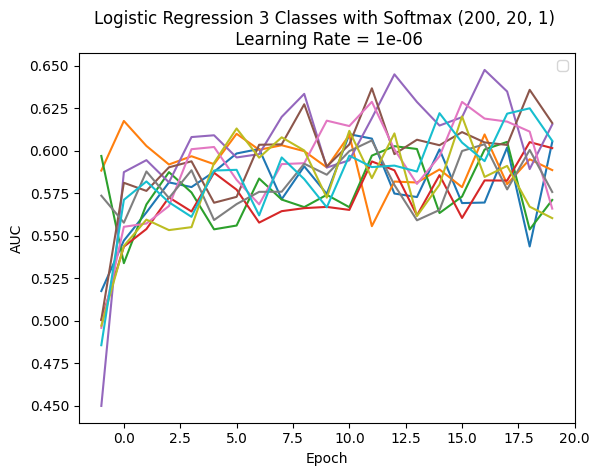


Test set: Avg. loss: 0.07073921966552735, AUC: 0.585565


Test set: Avg. loss: 0.03662685521443685, AUC: 0.5644144999999999


Test set: Avg. loss: 0.028429614384969076, AUC: 0.57736575


Test set: Avg. loss: 0.026529850006103514, AUC: 0.580871


Test set: Avg. loss: 0.028666133880615233, AUC: 0.57540025


Test set: Avg. loss: 0.026913888931274416, AUC: 0.5771875


Test set: Avg. loss: 0.030719886144002277, AUC: 0.56484475


Test set: Avg. loss: 0.027315757115681967, AUC: 0.57515375


Test set: Avg. loss: 0.022899372736612956, AUC: 0.5880305


Test set: Avg. loss: 0.02351551119486491, AUC: 0.58195475


Test set: Avg. loss: 0.02535218874613444, AUC: 0.5837202499999999


Test set: Avg. loss: 0.023142190297444663, AUC: 0.5836542500000002


Test set: Avg. loss: 0.022925483067830404, AUC: 0.5848425


Test set: Avg. loss: 0.020731065114339194, AUC: 0.5921875


Test set: Avg. loss: 0.01979443359375, AUC: 0.5942217500000001


Test set: Avg. loss: 0.02152230707804362, AUC: 0.5905587499999999





Test set: Avg. loss: 0.02278881899515788, AUC: 0.5860825000000001


Test set: Avg. loss: 0.02048284085591634, AUC: 0.5980265


Test set: Avg. loss: 0.026658838272094726, AUC: 0.57159275


Test set: Avg. loss: 0.021879920323689777, AUC: 0.5896474999999999


Test set: Avg. loss: 0.022435845692952473, AUC: 0.58381975


Test set: Avg. loss: 0.02054353396097819, AUC: 0.5919742499999999


Test set: Avg. loss: 0.018533954620361327, AUC: 0.6040435000000001


Test set: Avg. loss: 0.018079725901285808, AUC: 0.6062719999999999


Test set: Avg. loss: 0.01928549067179362, AUC: 0.595746


Test set: Avg. loss: 0.018059944788614907, AUC: 0.6040242499999999


Test set: Avg. loss: 0.02474098841349284, AUC: 0.5722014999999999


Test set: Avg. loss: 0.01835274887084961, AUC: 0.598422


Test set: Avg. loss: 0.021786529541015624, AUC: 0.5812649999999999


Test set: Avg. loss: 0.016831557591756186, AUC: 0.6068295


Test set: Avg. loss: 0.02879177220662435, AUC: 0.5664165


Test set: Avg. loss: 0.02580456415

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.017748774846394855, AUC: 0.5918699999999999



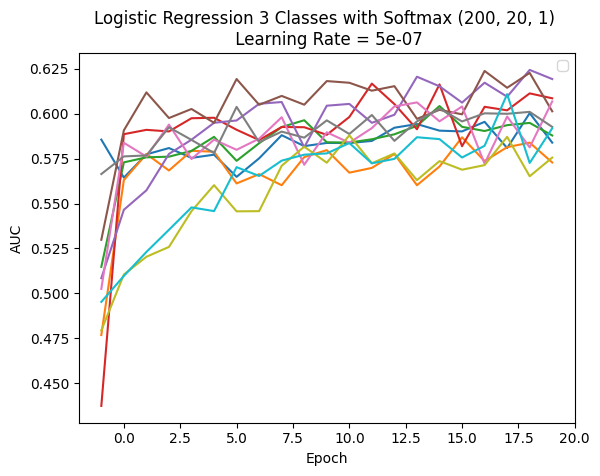


Test set: Avg. loss: 0.02947775459289551, AUC: 0.581955


Test set: Avg. loss: 0.026554670969645183, AUC: 0.5872475000000001


Test set: Avg. loss: 0.02574317487080892, AUC: 0.58876675


Test set: Avg. loss: 0.025376705169677733, AUC: 0.5902474999999999


Test set: Avg. loss: 0.02435366630554199, AUC: 0.59299475


Test set: Avg. loss: 0.02437908935546875, AUC: 0.5922310000000001


Test set: Avg. loss: 0.023133745829264325, AUC: 0.591863


Test set: Avg. loss: 0.023773714065551756, AUC: 0.593582


Test set: Avg. loss: 0.02350902239481608, AUC: 0.592595


Test set: Avg. loss: 0.022338474909464518, AUC: 0.59562725


Test set: Avg. loss: 0.022913465499877928, AUC: 0.5923640000000001


Test set: Avg. loss: 0.022149483998616538, AUC: 0.5946172500000001


Test set: Avg. loss: 0.02183950742085775, AUC: 0.59614775


Test set: Avg. loss: 0.021548407872517904, AUC: 0.5956482500000001


Test set: Avg. loss: 0.022384311040242515, AUC: 0.59188575


Test set: Avg. loss: 0.021493918736775718, AUC: 0.


Test set: Avg. loss: 0.031197419484456382, AUC: 0.5620605000000001


Test set: Avg. loss: 0.03012055778503418, AUC: 0.566578


Test set: Avg. loss: 0.030060221989949544, AUC: 0.56455875


Test set: Avg. loss: 0.02974600601196289, AUC: 0.5668075


Test set: Avg. loss: 0.028580206553141276, AUC: 0.5691269999999999


Test set: Avg. loss: 0.028906036376953125, AUC: 0.5684712500000001


Test set: Avg. loss: 0.029503725051879884, AUC: 0.56776625


Test set: Avg. loss: 0.028947345733642577, AUC: 0.5709112500000001


Test set: Avg. loss: 0.028506607055664063, AUC: 0.57175625


Test set: Avg. loss: 0.028951601664225262, AUC: 0.570942


Test set: Avg. loss: 0.026730599085489908, AUC: 0.57598


Test set: Avg. loss: 0.027530213673909506, AUC: 0.5736915


Test set: Avg. loss: 0.02820364252726237, AUC: 0.57365325


Test set: Avg. loss: 0.028075108846028644, AUC: 0.5746242500000001


Test set: Avg. loss: 0.0268929443359375, AUC: 0.57564725


Test set: Avg. loss: 0.027292678833007813, AUC: 0.57596799

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.02059406534830729, AUC: 0.5981405000000001


Test set: Avg. loss: 0.021054542541503907, AUC: 0.59591275



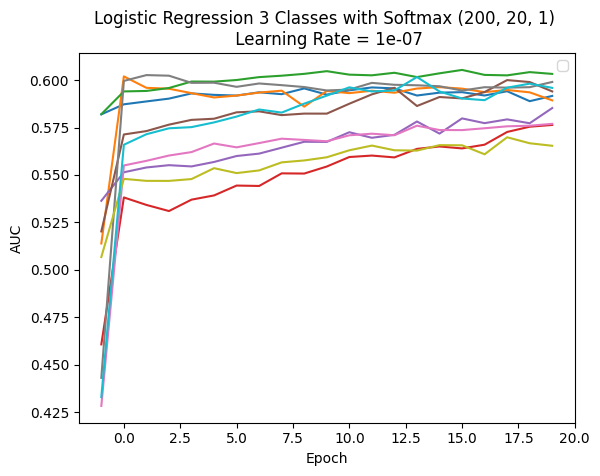


Test set: Avg. loss: 0.10243193562825521, AUC: 0.49550324999999995


Test set: Avg. loss: 0.06988294982910156, AUC: 0.4812652500000001


Test set: Avg. loss: 0.040827809651692706, AUC: 0.4392190000000001


Test set: Avg. loss: 0.018103171666463216, AUC: 0.43598424999999996


Test set: Avg. loss: 0.014834521293640136, AUC: 0.6013795000000001


Test set: Avg. loss: 0.018519043604532878, AUC: 0.6171114999999999


Test set: Avg. loss: 0.021227570215861004, AUC: 0.612641


Test set: Avg. loss: 0.023105950037638347, AUC: 0.6103185


Test set: Avg. loss: 0.024436011632283528, AUC: 0.6053422500000001


Test set: Avg. loss: 0.025433102289835613, AUC: 0.6052035


Test set: Avg. loss: 0.0262218386332194, AUC: 0.6006174999999999


Test set: Avg. loss: 0.026794780095418295, AUC: 0.5983670000000001


Test set: Avg. loss: 0.02720760663350423, AUC: 0.594393


Test set: Avg. loss: 0.027557007471720376, AUC: 0.59187625


Test set: Avg. loss: 0.027822252909342447, AUC: 0.59187075


Test set: Avg. loss: 


Test set: Avg. loss: 0.039965696970621745, AUC: 0.4655


Test set: Avg. loss: 0.042921478271484376, AUC: 0.47075


Test set: Avg. loss: 0.04476989237467448, AUC: 0.47475


Test set: Avg. loss: 0.0459423713684082, AUC: 0.48075


Test set: Avg. loss: 0.04663138071695964, AUC: 0.4845


Test set: Avg. loss: 0.04697609329223633, AUC: 0.48574999999999996


Test set: Avg. loss: 0.04717296346028646, AUC: 0.48750000000000004


Test set: Avg. loss: 0.04722044118245443, AUC: 0.48750000000000004


Test set: Avg. loss: 0.04719809977213542, AUC: 0.48800000000000004


Test set: Avg. loss: 0.047137393951416015, AUC: 0.4877500000000001


Test set: Avg. loss: 0.04707146708170573, AUC: 0.4882500000000001


Test set: Avg. loss: 0.04694729105631511, AUC: 0.48800000000000004


Test set: Avg. loss: 0.04680800247192383, AUC: 0.48850000000000005


Test set: Avg. loss: 0.04663952509562175, AUC: 0.4895


Test set: Avg. loss: 0.04644524383544922, AUC: 0.48924999999999996


Test set: Avg. loss: 0.0462395807902018

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.032488293965657555, AUC: 0.612466


Test set: Avg. loss: 0.03245992469787597, AUC: 0.6114255000000001



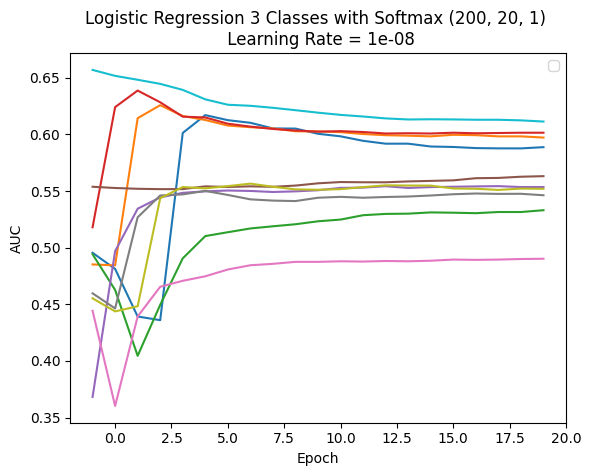


Test set: Avg. loss: 0.13471880086263022, AUC: 0.528


Test set: Avg. loss: 0.13433220926920572, AUC: 0.5282499999999999


Test set: Avg. loss: 0.13394476318359375, AUC: 0.5282499999999999


Test set: Avg. loss: 0.1335598856608073, AUC: 0.5282499999999999


Test set: Avg. loss: 0.133174072265625, AUC: 0.5282499999999999


Test set: Avg. loss: 0.13279146830240884, AUC: 0.5282499999999999


Test set: Avg. loss: 0.1324073994954427, AUC: 0.5282499999999999


Test set: Avg. loss: 0.13202070617675782, AUC: 0.5285


Test set: Avg. loss: 0.13163888549804686, AUC: 0.52875


Test set: Avg. loss: 0.13125697326660157, AUC: 0.5289999999999999


Test set: Avg. loss: 0.13087206013997396, AUC: 0.5289999999999999


Test set: Avg. loss: 0.1304827372233073, AUC: 0.5292499999999999


Test set: Avg. loss: 0.13010389709472656, AUC: 0.5287499999999999


Test set: Avg. loss: 0.12971956888834635, AUC: 0.5287499999999999


Test set: Avg. loss: 0.12933787790934245, AUC: 0.5287499999999999


Test set: Avg. loss:


Test set: Avg. loss: 0.013632026672363282, AUC: 0.5543037500000001


Test set: Avg. loss: 0.012883250872294107, AUC: 0.5685945


Test set: Avg. loss: 0.0124408753712972, AUC: 0.57835075


Test set: Avg. loss: 0.012251668294270834, AUC: 0.5842849999999999


Test set: Avg. loss: 0.01225440247853597, AUC: 0.6014885000000001


Test set: Avg. loss: 0.012409620602925619, AUC: 0.61003625


Test set: Avg. loss: 0.012662367502848307, AUC: 0.6106415000000001


Test set: Avg. loss: 0.012985090891520182, AUC: 0.6112147499999999


Test set: Avg. loss: 0.013353161811828614, AUC: 0.6158950000000001


Test set: Avg. loss: 0.013742390314737956, AUC: 0.6170299999999999


Test set: Avg. loss: 0.014147608439127605, AUC: 0.619405


Test set: Avg. loss: 0.01456455135345459, AUC: 0.61788075


Test set: Avg. loss: 0.014980898221333822, AUC: 0.61730725


Test set: Avg. loss: 0.03384248352050781, AUC: 0.5174075


Test set: Avg. loss: 0.03156598726908366, AUC: 0.51505


Test set: Avg. loss: 0.029422018051147462

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.059203116099039714, AUC: 0.532608


Test set: Avg. loss: 0.05895269648234049, AUC: 0.5325925



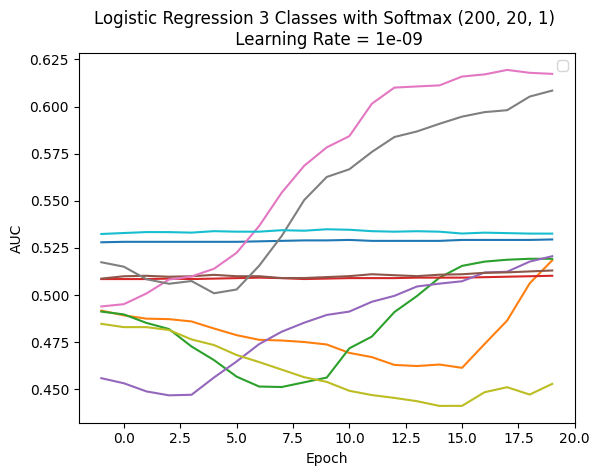

In [27]:
# SOFTMAX 3 class ratio

momentum=0
learning_rates = [0.0001, 1e-5, 1e-6, 5e-7, 1e-7, 1e-8, 1e-9]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(3, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/reduced{i}/model{epoch}"
            directory=None
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, directory=directory)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 3 Classes with Softmax " + str(ratio) + " \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()


Test set: Avg. loss: 0.02285408846537272, AUC: 0.54853025


Test set: Avg. loss: 0.031149574915568034, AUC: 0.7117735000000001


Test set: Avg. loss: 0.015518822669982911, AUC: 0.767076


Test set: Avg. loss: 0.07315890757242839, AUC: 0.5365


Test set: Avg. loss: 0.04444103876749674, AUC: 0.6742635


Test set: Avg. loss: 0.022128998438517254, AUC: 0.70925


Test set: Avg. loss: 0.01537865130106608, AUC: 0.778


Test set: Avg. loss: 0.027412062962849936, AUC: 0.673


Test set: Avg. loss: 0.015757028897603352, AUC: 0.7597499999999999


Test set: Avg. loss: 0.03411121877034505, AUC: 0.704


Test set: Avg. loss: 0.11333473459879558, AUC: 0.50675


Test set: Avg. loss: 0.01931798235575358, AUC: 0.7669999999999999


Test set: Avg. loss: 0.019569820404052734, AUC: 0.7725


Test set: Avg. loss: 0.026045442581176758, AUC: 0.7559999999999999


Test set: Avg. loss: 0.021462764739990235, AUC: 0.714


Test set: Avg. loss: 0.019962034225463866, AUC: 0.769


Test set: Avg. loss: 0.02919779777526855


Test set: Avg. loss: 0.029117478688557942, AUC: 0.7407500000000001


Test set: Avg. loss: 0.03486048571268718, AUC: 0.6232500000000001


Test set: Avg. loss: 0.03030479431152344, AUC: 0.73375


Test set: Avg. loss: 0.07178412628173828, AUC: 0.60575


Test set: Avg. loss: 0.03193164126078288, AUC: 0.66025


Test set: Avg. loss: 0.015725316365559894, AUC: 0.774


Test set: Avg. loss: 0.018127620697021483, AUC: 0.735


Test set: Avg. loss: 0.05007715861002604, AUC: 0.6505


Test set: Avg. loss: 0.02965659459431966, AUC: 0.73225


Test set: Avg. loss: 0.12685872141520182, AUC: 0.5419999999999999


Test set: Avg. loss: 0.01873244539896647, AUC: 0.75


Test set: Avg. loss: 0.020343671798706053, AUC: 0.7162499999999999


Test set: Avg. loss: 0.038779052734375, AUC: 0.608


Test set: Avg. loss: 0.027835976282755533, AUC: 0.752


Test set: Avg. loss: 0.02295106633504232, AUC: 0.70025


Test set: Avg. loss: 0.01748924732208252, AUC: 0.75625


Test set: Avg. loss: 0.041627811431884765, AUC: 0.44


Test set: Avg. loss: 0.024962377548217774, AUC: 0.6895


Test set: Avg. loss: 0.038078015645345055, AUC: 0.6172500000000001


Test set: Avg. loss: 0.04512557601928711, AUC: 0.58725


Test set: Avg. loss: 0.03082605806986491, AUC: 0.73075


Test set: Avg. loss: 0.11071785736083985, AUC: 0.50925


Test set: Avg. loss: 0.01734943135579427, AUC: 0.7620000000000001


Test set: Avg. loss: 0.018168187459309895, AUC: 0.77325


Test set: Avg. loss: 0.016337958017985026, AUC: 0.78725


Test set: Avg. loss: 0.017198201497395833, AUC: 0.7345


Test set: Avg. loss: 0.017025582631429035, AUC: 0.7772499999999999


Test set: Avg. loss: 0.060781968434651695, AUC: 0.55625


Test set: Avg. loss: 0.10144208526611329, AUC: 0.5694999999999999


Test set: Avg. loss: 0.03501805877685547, AUC: 0.7125000000000001


Test set: Avg. loss: 0.06873143005371093, AUC: 0.5375


Test set: Avg. loss: 0.023959124247233073, AUC: 0.6955


Test set: Avg. loss: 0.050840887705485026, AUC: 0.568


Test set: Avg. loss: 0.029676


Test set: Avg. loss: 0.04424093373616537, AUC: 0.6005


Test set: Avg. loss: 0.031006634394327798, AUC: 0.7212500000000001


Test set: Avg. loss: 0.016530813217163084, AUC: 0.7697499999999999


Test set: Avg. loss: 0.02805804252624512, AUC: 0.718


Test set: Avg. loss: 0.02307250467936198, AUC: 0.68125


Test set: Avg. loss: 0.01866889762878418, AUC: 0.7375


Test set: Avg. loss: 0.05858846537272135, AUC: 0.6335000000000001


Test set: Avg. loss: 0.017736633936564127, AUC: 0.7507499999999999


Test set: Avg. loss: 0.07781618499755859, AUC: 0.528


Test set: Avg. loss: 0.01726666259765625, AUC: 0.77275


Test set: Avg. loss: 0.07590804036458333, AUC: 0.59125


Test set: Avg. loss: 0.021119394302368165, AUC: 0.7125


Test set: Avg. loss: 0.015322001457214355, AUC: 0.77675


Test set: Avg. loss: 0.031076220194498697, AUC: 0.7162499999999999


Test set: Avg. loss: 0.05731862767537435, AUC: 0.6399999999999999


Test set: Avg. loss: 0.019041860580444336, AUC: 0.77525


Test set: Avg. loss: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0581392453511556, AUC: 0.54975



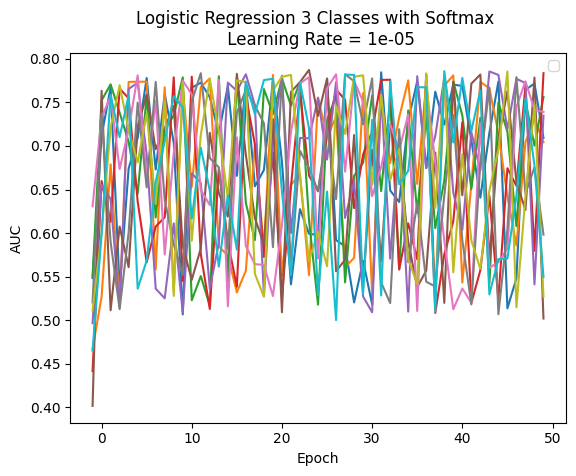


Test set: Avg. loss: 0.024090087254842123, AUC: 0.47493199999999997


Test set: Avg. loss: 0.007319186528523763, AUC: 0.682788


Test set: Avg. loss: 0.006352080821990967, AUC: 0.64194


Test set: Avg. loss: 0.007017975330352783, AUC: 0.620406


Test set: Avg. loss: 0.00498179276784261, AUC: 0.698851


Test set: Avg. loss: 0.005143246014912923, AUC: 0.66177


Test set: Avg. loss: 0.006302983601888021, AUC: 0.701321


Test set: Avg. loss: 0.004453612565994263, AUC: 0.7123825


Test set: Avg. loss: 0.004075939337412516, AUC: 0.690574


Test set: Avg. loss: 0.004145801385243734, AUC: 0.6794955


Test set: Avg. loss: 0.004238032341003418, AUC: 0.7083645000000001


Test set: Avg. loss: 0.007438757260640462, AUC: 0.67052075


Test set: Avg. loss: 0.0035237402121225995, AUC: 0.70934875


Test set: Avg. loss: 0.013156856536865234, AUC: 0.590258


Test set: Avg. loss: 0.009175518989562988, AUC: 0.53647725


Test set: Avg. loss: 0.004682078838348389, AUC: 0.718033


Test set: Avg. loss: 0.00408


Test set: Avg. loss: 0.0028975250720977785, AUC: 0.7469999999999998


Test set: Avg. loss: 0.00258626921971639, AUC: 0.71525


Test set: Avg. loss: 0.0024734191099802655, AUC: 0.7284999999999999


Test set: Avg. loss: 0.008083312511444092, AUC: 0.53625


Test set: Avg. loss: 0.0033004241784413656, AUC: 0.7325


Test set: Avg. loss: 0.002857157309850057, AUC: 0.6839999999999999


Test set: Avg. loss: 0.0027457985877990723, AUC: 0.701


Test set: Avg. loss: 0.002558644771575928, AUC: 0.7444999999999999


Test set: Avg. loss: 0.0059679857889811195, AUC: 0.56125


Test set: Avg. loss: 0.005197927951812744, AUC: 0.582


Test set: Avg. loss: 0.010269988059997558, AUC: 0.5935


Test set: Avg. loss: 0.00245888090133667, AUC: 0.721


Test set: Avg. loss: 0.0023214333057403566, AUC: 0.734


Test set: Avg. loss: 0.0025574817657470703, AUC: 0.698


Test set: Avg. loss: 0.0029340978463490803, AUC: 0.7414999999999999


Test set: Avg. loss: 0.0027440489927927653, AUC: 0.677


Test set: Avg. loss: 0.


Test set: Avg. loss: 0.00616182009379069, AUC: 0.58475


Test set: Avg. loss: 0.00690889056523641, AUC: 0.688


Test set: Avg. loss: 0.004427245299021403, AUC: 0.7145


Test set: Avg. loss: 0.014031598409016927, AUC: 0.50825


Test set: Avg. loss: 0.0050963258743286135, AUC: 0.71125


Test set: Avg. loss: 0.00426591444015503, AUC: 0.718


Test set: Avg. loss: 0.0035287254651387534, AUC: 0.6757500000000001


Test set: Avg. loss: 0.0032962987422943115, AUC: 0.72775


Test set: Avg. loss: 0.00463820219039917, AUC: 0.6092500000000001


Test set: Avg. loss: 0.0034462029933929445, AUC: 0.67225


Test set: Avg. loss: 0.0031167815526326496, AUC: 0.71325


Test set: Avg. loss: 0.003208822727203369, AUC: 0.6960000000000001


Test set: Avg. loss: 0.008859058380126954, AUC: 0.6305


Test set: Avg. loss: 0.0034398364226023354, AUC: 0.673


Test set: Avg. loss: 0.0030007171630859375, AUC: 0.705


Test set: Avg. loss: 0.005741271336873372, AUC: 0.6905


Test set: Avg. loss: 0.006842739105224609, AUC


Test set: Avg. loss: 0.002594530502955119, AUC: 0.7063192500000001


Test set: Avg. loss: 0.0034672811031341553, AUC: 0.64978725


Test set: Avg. loss: 0.003091952085494995, AUC: 0.66479775


Test set: Avg. loss: 0.0024129532178243, AUC: 0.72332675


Test set: Avg. loss: 0.00413071346282959, AUC: 0.71848175


Test set: Avg. loss: 0.0025427706241607667, AUC: 0.708067


Test set: Avg. loss: 0.002784470796585083, AUC: 0.68480725


Test set: Avg. loss: 0.0024006249904632566, AUC: 0.751626


Test set: Avg. loss: 0.0024713266690572105, AUC: 0.716069


Test set: Avg. loss: 0.003955437262852987, AUC: 0.6147797500000001


Test set: Avg. loss: 0.007726359049479167, AUC: 0.53775425


Test set: Avg. loss: 0.005083202838897705, AUC: 0.5757632500000001


Test set: Avg. loss: 0.011648379961649576, AUC: 0.5821537499999999


Test set: Avg. loss: 0.03965804163614909, AUC: 0.492234


Test set: Avg. loss: 0.009453000704447429, AUC: 0.58942875


Test set: Avg. loss: 0.006173810640970866, AUC: 0.68633475



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.002632978836695353, AUC: 0.71175



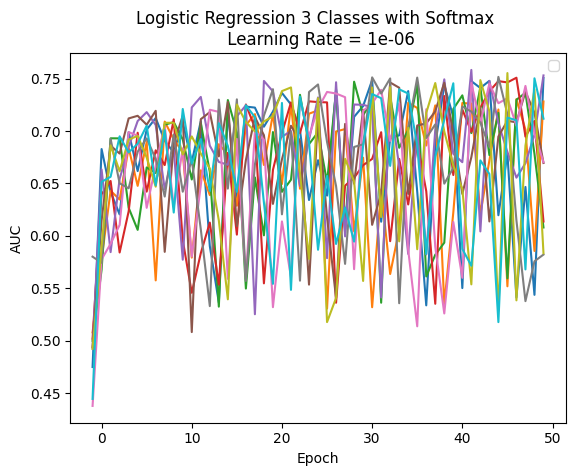


Test set: Avg. loss: 0.058300403594970705, AUC: 0.49525


Test set: Avg. loss: 0.009151482264200846, AUC: 0.613


Test set: Avg. loss: 0.007286808808644613, AUC: 0.6495


Test set: Avg. loss: 0.006577003955841065, AUC: 0.675


Test set: Avg. loss: 0.00605281400680542, AUC: 0.6575


Test set: Avg. loss: 0.005823620796203613, AUC: 0.6505000000000001


Test set: Avg. loss: 0.005403842767079671, AUC: 0.66


Test set: Avg. loss: 0.0052097312609354655, AUC: 0.6625000000000001


Test set: Avg. loss: 0.004983880678812663, AUC: 0.6899999999999998


Test set: Avg. loss: 0.004988043944040934, AUC: 0.6970000000000001


Test set: Avg. loss: 0.0048189686139424644, AUC: 0.6525


Test set: Avg. loss: 0.004496189435323079, AUC: 0.664


Test set: Avg. loss: 0.005727488994598389, AUC: 0.6035


Test set: Avg. loss: 0.004275899012883504, AUC: 0.66625


Test set: Avg. loss: 0.004027836640675863, AUC: 0.6795


Test set: Avg. loss: 0.0040570592880249026, AUC: 0.7072499999999999


Test set: Avg. loss: 0.00383


Test set: Avg. loss: 0.0037540836334228516, AUC: 0.7135


Test set: Avg. loss: 0.003410659392674764, AUC: 0.6639999999999999


Test set: Avg. loss: 0.0037409793535868327, AUC: 0.70925


Test set: Avg. loss: 0.0034275647004445393, AUC: 0.65525


Test set: Avg. loss: 0.0031767006715138755, AUC: 0.6925


Test set: Avg. loss: 0.003534947951634725, AUC: 0.6425000000000001


Test set: Avg. loss: 0.003308009703954061, AUC: 0.6615


Test set: Avg. loss: 0.0031053884824117023, AUC: 0.695


Test set: Avg. loss: 0.003087585608164469, AUC: 0.667


Test set: Avg. loss: 0.0030625537236531573, AUC: 0.6977499999999999


Test set: Avg. loss: 0.0029626944859822593, AUC: 0.6887500000000001


Test set: Avg. loss: 0.0030248332023620605, AUC: 0.6685


Test set: Avg. loss: 0.0029536882241566974, AUC: 0.701


Test set: Avg. loss: 0.0030227108001708984, AUC: 0.6635


Test set: Avg. loss: 0.00291964324315389, AUC: 0.6697500000000001


Test set: Avg. loss: 0.002986599604288737, AUC: 0.6607500000000001


Test se


Test set: Avg. loss: 0.004932591597239177, AUC: 0.67010975


Test set: Avg. loss: 0.004713156700134277, AUC: 0.68059375


Test set: Avg. loss: 0.004973773956298828, AUC: 0.6903175


Test set: Avg. loss: 0.004662897109985352, AUC: 0.660625


Test set: Avg. loss: 0.004631018320719401, AUC: 0.661879


Test set: Avg. loss: 0.004164222876230876, AUC: 0.6801032499999999


Test set: Avg. loss: 0.0040985109806060795, AUC: 0.6890839999999999


Test set: Avg. loss: 0.003947690645853678, AUC: 0.68010275


Test set: Avg. loss: 0.00415538756052653, AUC: 0.660628


Test set: Avg. loss: 0.0040442143281300864, AUC: 0.70206775


Test set: Avg. loss: 0.004132484436035156, AUC: 0.698


Test set: Avg. loss: 0.003681749979654948, AUC: 0.6765


Test set: Avg. loss: 0.003670669476191203, AUC: 0.66825


Test set: Avg. loss: 0.0036328648726145427, AUC: 0.6975000000000001


Test set: Avg. loss: 0.0035550781885782877, AUC: 0.7000000000000001


Test set: Avg. loss: 0.0035559446016947428, AUC: 0.6669999999999999



Test set: Avg. loss: 0.002660187641779582, AUC: 0.7175745


Test set: Avg. loss: 0.003082852602005005, AUC: 0.6501425000000001


Test set: Avg. loss: 0.0031708598136901854, AUC: 0.7160475


Test set: Avg. loss: 0.002561681588490804, AUC: 0.7020919999999999


Test set: Avg. loss: 0.0028966355323791506, AUC: 0.7155565


Test set: Avg. loss: 0.002585667610168457, AUC: 0.71682175


Test set: Avg. loss: 0.002493710915247599, AUC: 0.70458975


Test set: Avg. loss: 0.003393754243850708, AUC: 0.7125372499999999


Test set: Avg. loss: 0.0024721789360046386, AUC: 0.71108125


Test set: Avg. loss: 0.002435654640197754, AUC: 0.70783625


Test set: Avg. loss: 0.0027393181324005126, AUC: 0.65088825


Test set: Avg. loss: 0.0026404582659403483, AUC: 0.661131


Test set: Avg. loss: 0.002405868371327718, AUC: 0.69360075


Test set: Avg. loss: 0.0023898708820343016, AUC: 0.719077


Test set: Avg. loss: 0.0023463215827941894, AUC: 0.71383575


Test set: Avg. loss: 0.0024879230658213297, AUC: 0.72206375


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0027165804704030357, AUC: 0.6701225



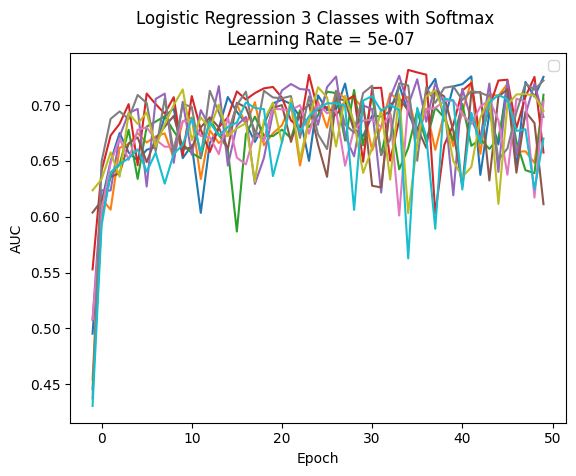


Test set: Avg. loss: 0.043843714396158855, AUC: 0.5167057500000001


Test set: Avg. loss: 0.016766712188720702, AUC: 0.49617274999999994


Test set: Avg. loss: 0.01349928092956543, AUC: 0.534073


Test set: Avg. loss: 0.011472614924112955, AUC: 0.568126


Test set: Avg. loss: 0.010183096567789714, AUC: 0.5851237499999999


Test set: Avg. loss: 0.009298666000366211, AUC: 0.6003094999999999


Test set: Avg. loss: 0.008682922045389811, AUC: 0.60892


Test set: Avg. loss: 0.008161749998728434, AUC: 0.6179815


Test set: Avg. loss: 0.0077972591718037925, AUC: 0.6314329999999999


Test set: Avg. loss: 0.007524822076161702, AUC: 0.6395255


Test set: Avg. loss: 0.007300080299377442, AUC: 0.636164


Test set: Avg. loss: 0.007150328477223715, AUC: 0.63310875


Test set: Avg. loss: 0.006987689177195231, AUC: 0.63834125


Test set: Avg. loss: 0.006849702835083008, AUC: 0.6469480000000001


Test set: Avg. loss: 0.006739504814147949, AUC: 0.649181


Test set: Avg. loss: 0.006734999974568685, AUC: 


Test set: Avg. loss: 0.00530368725458781, AUC: 0.67624125


Test set: Avg. loss: 0.005248325030008952, AUC: 0.6812250000000001


Test set: Avg. loss: 0.005182876427968343, AUC: 0.680884


Test set: Avg. loss: 0.005133043448130289, AUC: 0.683029


Test set: Avg. loss: 0.005084596951802572, AUC: 0.67082475


Test set: Avg. loss: 0.0050079878171285, AUC: 0.6827865


Test set: Avg. loss: 0.004969440937042237, AUC: 0.6832767499999999


Test set: Avg. loss: 0.004897681554158529, AUC: 0.67954775


Test set: Avg. loss: 0.004851613998413086, AUC: 0.6811924999999999


Test set: Avg. loss: 0.0048099182446797685, AUC: 0.6747110000000001


Test set: Avg. loss: 0.004783083915710449, AUC: 0.6737164999999999


Test set: Avg. loss: 0.004729586442311605, AUC: 0.6871805


Test set: Avg. loss: 0.004713558514912924, AUC: 0.670971


Test set: Avg. loss: 0.004622871398925781, AUC: 0.6806945


Test set: Avg. loss: 0.004579859256744385, AUC: 0.6826964999999999


Test set: Avg. loss: 0.004561038812001547, AUC:


Test set: Avg. loss: 0.00740706221262614, AUC: 0.6467632499999999


Test set: Avg. loss: 0.007267062187194824, AUC: 0.6422922499999999


Test set: Avg. loss: 0.007134712378184, AUC: 0.6429275


Test set: Avg. loss: 0.007065751393636068, AUC: 0.6583225


Test set: Avg. loss: 0.006893052101135254, AUC: 0.6455525


Test set: Avg. loss: 0.006786134560902914, AUC: 0.6476815


Test set: Avg. loss: 0.006701954205830892, AUC: 0.6581345000000001


Test set: Avg. loss: 0.006592712243398031, AUC: 0.6461855000000001


Test set: Avg. loss: 0.006508939107259115, AUC: 0.6581379999999999


Test set: Avg. loss: 0.006418721834818522, AUC: 0.6585352499999999


Test set: Avg. loss: 0.0063433944384257, AUC: 0.6429635


Test set: Avg. loss: 0.006286979993184408, AUC: 0.6614265


Test set: Avg. loss: 0.006186108589172363, AUC: 0.65583375


Test set: Avg. loss: 0.006121311028798421, AUC: 0.65808125


Test set: Avg. loss: 0.0061415518124898275, AUC: 0.664328


Test set: Avg. loss: 0.006050348122914632, AUC: 0


Test set: Avg. loss: 0.005099086761474609, AUC: 0.6729430000000001


Test set: Avg. loss: 0.005069621721903483, AUC: 0.6629725


Test set: Avg. loss: 0.005021952629089356, AUC: 0.676938


Test set: Avg. loss: 0.004972080707550049, AUC: 0.6754420000000001


Test set: Avg. loss: 0.004955250898996989, AUC: 0.6779345


Test set: Avg. loss: 0.004915447076161703, AUC: 0.6602260000000001


Test set: Avg. loss: 0.004851141134897868, AUC: 0.6756985


Test set: Avg. loss: 0.0048187365531921385, AUC: 0.6749475


Test set: Avg. loss: 0.0047940402030944825, AUC: 0.6766920000000001


Test set: Avg. loss: 0.004793081442515055, AUC: 0.67993


Test set: Avg. loss: 0.004717307249704997, AUC: 0.674949


Test set: Avg. loss: 0.004688024838765462, AUC: 0.6709594999999999


Test set: Avg. loss: 0.004665836652119955, AUC: 0.675944


Test set: Avg. loss: 0.004639008363087972, AUC: 0.675943


Test set: Avg. loss: 0.0046089064280192054, AUC: 0.6756935


Test set: Avg. loss: 0.004583121458689372, AUC: 0.6639704

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.004440176486968994, AUC: 0.67475



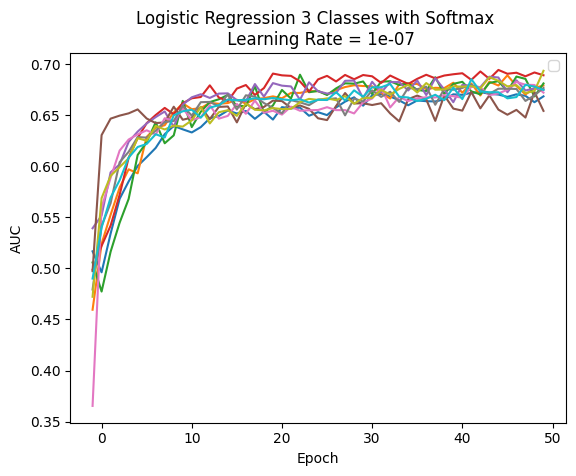


Test set: Avg. loss: 0.06349305852254232, AUC: 0.47177975


Test set: Avg. loss: 0.020616377512613932, AUC: 0.54991975


Test set: Avg. loss: 0.01738170305887858, AUC: 0.5259194999999999


Test set: Avg. loss: 0.016195249557495118, AUC: 0.507875


Test set: Avg. loss: 0.01544560686747233, AUC: 0.49713199999999996


Test set: Avg. loss: 0.014878779411315919, AUC: 0.49737750000000003


Test set: Avg. loss: 0.014414363225301107, AUC: 0.49697074999999996


Test set: Avg. loss: 0.013995887438456218, AUC: 0.500297


Test set: Avg. loss: 0.0136215607325236, AUC: 0.50201825


Test set: Avg. loss: 0.013282036463419597, AUC: 0.506678


Test set: Avg. loss: 0.012967714627583822, AUC: 0.50976075


Test set: Avg. loss: 0.012670241991678873, AUC: 0.511872


Test set: Avg. loss: 0.012369548479715983, AUC: 0.51556625


Test set: Avg. loss: 0.012098999341328938, AUC: 0.51934


Test set: Avg. loss: 0.01184900951385498, AUC: 0.5203552499999999


Test set: Avg. loss: 0.011595333099365234, AUC: 0.524668




Test set: Avg. loss: 0.008798035303751627, AUC: 0.6416487500000001


Test set: Avg. loss: 0.008737050056457519, AUC: 0.6422899999999999


Test set: Avg. loss: 0.008679334004720053, AUC: 0.64268075


Test set: Avg. loss: 0.0086248566309611, AUC: 0.6451730000000001


Test set: Avg. loss: 0.008569044748942057, AUC: 0.6434277500000001


Test set: Avg. loss: 0.008517730394999186, AUC: 0.6446725


Test set: Avg. loss: 0.008468827883402507, AUC: 0.6440665


Test set: Avg. loss: 0.008421830336252848, AUC: 0.6443157500000001


Test set: Avg. loss: 0.008376947244008382, AUC: 0.6453127500000001


Test set: Avg. loss: 0.008333767573038737, AUC: 0.6453127500000001


Test set: Avg. loss: 0.008292142550150554, AUC: 0.64481425


Test set: Avg. loss: 0.008252435525258383, AUC: 0.6440665


Test set: Avg. loss: 0.008215211232503255, AUC: 0.6442065


Test set: Avg. loss: 0.008176624139149984, AUC: 0.64445625


Test set: Avg. loss: 0.008142158508300782, AUC: 0.6459532499999999


Test set: Avg. loss: 0.008


Test set: Avg. loss: 0.013787070274353027, AUC: 0.5330555


Test set: Avg. loss: 0.013520233472188314, AUC: 0.533508


Test set: Avg. loss: 0.013258708318074545, AUC: 0.5343005


Test set: Avg. loss: 0.013024497985839843, AUC: 0.535115


Test set: Avg. loss: 0.01281354554494222, AUC: 0.5409925


Test set: Avg. loss: 0.012608745257059734, AUC: 0.541067


Test set: Avg. loss: 0.012419040997823079, AUC: 0.5469085


Test set: Avg. loss: 0.012242055892944336, AUC: 0.5509809999999999


Test set: Avg. loss: 0.012070818901062012, AUC: 0.552794


Test set: Avg. loss: 0.011912883440653483, AUC: 0.5555574999999999


Test set: Avg. loss: 0.011762488683064778, AUC: 0.55849975


Test set: Avg. loss: 0.011620866139729819, AUC: 0.5599594999999999


Test set: Avg. loss: 0.011490441004435222, AUC: 0.56414975


Test set: Avg. loss: 0.01136343765258789, AUC: 0.56462325


Test set: Avg. loss: 0.01123804251352946, AUC: 0.5653755


Test set: Avg. loss: 0.011116638501485188, AUC: 0.5652395


Test set: Avg. l


Test set: Avg. loss: 0.010312841733296713, AUC: 0.5909812499999999


Test set: Avg. loss: 0.010244361241658529, AUC: 0.589997


Test set: Avg. loss: 0.010170368830362956, AUC: 0.59247275


Test set: Avg. loss: 0.01010102621714274, AUC: 0.5934625


Test set: Avg. loss: 0.01003619384765625, AUC: 0.5948375


Test set: Avg. loss: 0.009974223454793294, AUC: 0.595092


Test set: Avg. loss: 0.009913104057312012, AUC: 0.5973375


Test set: Avg. loss: 0.009849446296691895, AUC: 0.60128875


Test set: Avg. loss: 0.009791028658548992, AUC: 0.6024112500000001


Test set: Avg. loss: 0.009729885737101237, AUC: 0.6073737499999999


Test set: Avg. loss: 0.009674572626749674, AUC: 0.60799775


Test set: Avg. loss: 0.009619166692097982, AUC: 0.61023875


Test set: Avg. loss: 0.00956558100382487, AUC: 0.61173275


Test set: Avg. loss: 0.009515452702840169, AUC: 0.612239


Test set: Avg. loss: 0.016444754282633464, AUC: 0.4982289999999999


Test set: Avg. loss: 0.010842806498209635, AUC: 0.548549


Test 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.00808476193745931, AUC: 0.6121015000000001



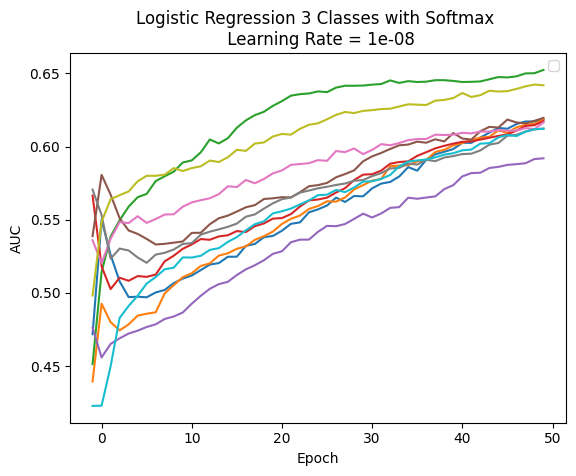


Test set: Avg. loss: 0.041568949381510414, AUC: 0.54642275


Test set: Avg. loss: 0.03567887624104818, AUC: 0.5507195000000001


Test set: Avg. loss: 0.03069490877787272, AUC: 0.565936


Test set: Avg. loss: 0.026706836700439454, AUC: 0.5683565


Test set: Avg. loss: 0.023658921559651692, AUC: 0.561012


Test set: Avg. loss: 0.021444538752237955, AUC: 0.5651287500000001


Test set: Avg. loss: 0.019860259373982746, AUC: 0.55535


Test set: Avg. loss: 0.018760107676188152, AUC: 0.54468875


Test set: Avg. loss: 0.018020331700642905, AUC: 0.53935325


Test set: Avg. loss: 0.017516483306884767, AUC: 0.53299925


Test set: Avg. loss: 0.01718282953898112, AUC: 0.5303005000000001


Test set: Avg. loss: 0.01694907824198405, AUC: 0.521209


Test set: Avg. loss: 0.01678545633951823, AUC: 0.5184067499999999


Test set: Avg. loss: 0.016665550231933595, AUC: 0.5140995


Test set: Avg. loss: 0.016572525024414062, AUC: 0.514848


Test set: Avg. loss: 0.016497540791829426, AUC: 0.5146124999999999


T


Test set: Avg. loss: 0.012945175170898438, AUC: 0.501622


Test set: Avg. loss: 0.012912861188252767, AUC: 0.5024375


Test set: Avg. loss: 0.012880871772766114, AUC: 0.50259875


Test set: Avg. loss: 0.012849477132161459, AUC: 0.5028462499999999


Test set: Avg. loss: 0.012818834622701008, AUC: 0.504131


Test set: Avg. loss: 0.012788227081298828, AUC: 0.503331


Test set: Avg. loss: 0.012758164405822755, AUC: 0.50326


Test set: Avg. loss: 0.01272844664255778, AUC: 0.5034244999999999


Test set: Avg. loss: 0.012699126561482747, AUC: 0.5033425


Test set: Avg. loss: 0.012670087814331054, AUC: 0.5033425


Test set: Avg. loss: 0.0126412566502889, AUC: 0.5058612499999999


Test set: Avg. loss: 0.012612988154093424, AUC: 0.5069857499999999


Test set: Avg. loss: 0.012584909121195476, AUC: 0.5075605


Test set: Avg. loss: 0.012556960423787435, AUC: 0.50830375


Test set: Avg. loss: 0.012529364267985026, AUC: 0.50911575


Test set: Avg. loss: 0.012502309163411458, AUC: 0.50961125


Test se


Test set: Avg. loss: 0.09237859344482421, AUC: 0.46696025


Test set: Avg. loss: 0.08436499786376953, AUC: 0.47499075


Test set: Avg. loss: 0.07828279113769532, AUC: 0.49243024999999996


Test set: Avg. loss: 0.07353815205891927, AUC: 0.52594175


Test set: Avg. loss: 0.06968095143636067, AUC: 0.542086


Test set: Avg. loss: 0.06633990478515625, AUC: 0.557084


Test set: Avg. loss: 0.06333008702596028, AUC: 0.5655542499999999


Test set: Avg. loss: 0.06054188791910807, AUC: 0.5681977500000001


Test set: Avg. loss: 0.0579043935139974, AUC: 0.576017


Test set: Avg. loss: 0.05538596725463867, AUC: 0.5792255


Test set: Avg. loss: 0.05295438766479492, AUC: 0.5750335


Test set: Avg. loss: 0.05060217030843099, AUC: 0.5774972499999999


Test set: Avg. loss: 0.04832482147216797, AUC: 0.5767819999999999


Test set: Avg. loss: 0.04612663396199544, AUC: 0.57727325


Test set: Avg. loss: 0.04400822067260742, AUC: 0.5740575


Test set: Avg. loss: 0.041970330556233726, AUC: 0.575724


Test set:


Test set: Avg. loss: 0.01230248228708903, AUC: 0.58290725


Test set: Avg. loss: 0.012224023183186848, AUC: 0.5827180000000001


Test set: Avg. loss: 0.012150425593058269, AUC: 0.58215675


Test set: Avg. loss: 0.012080557823181152, AUC: 0.5796614999999999


Test set: Avg. loss: 0.012014488855997721, AUC: 0.578333


Test set: Avg. loss: 0.011951686541239421, AUC: 0.576819


Test set: Avg. loss: 0.011892145156860351, AUC: 0.575767


Test set: Avg. loss: 0.01183544921875, AUC: 0.57615175


Test set: Avg. loss: 0.01178144105275472, AUC: 0.5762322499999999


Test set: Avg. loss: 0.01172968832651774, AUC: 0.5775669999999999


Test set: Avg. loss: 0.011679909388224283, AUC: 0.5775662500000001


Test set: Avg. loss: 0.011631879806518555, AUC: 0.5779839999999999


Test set: Avg. loss: 0.011585509300231934, AUC: 0.5771


Test set: Avg. loss: 0.011540829022725423, AUC: 0.5770445


Test set: Avg. loss: 0.011497712135314942, AUC: 0.57536775


Test set: Avg. loss: 0.011455662409464518, AUC: 0.5761

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.010718630154927572, AUC: 0.5861075



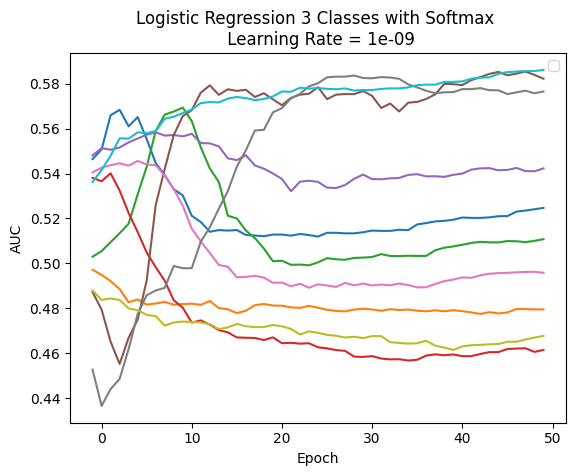

In [11]:
# Softmax 3 class

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8, 1e-9]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 3 Classes with Softmax \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()


Test set: Avg. loss: 0.06875008646647135, AUC: 0.5993094999999999


Test set: Avg. loss: 0.2866184488932292, AUC: 0.5217495


Test set: Avg. loss: 0.25034471130371094, AUC: 0.43925000000000003


Test set: Avg. loss: 0.07189195760091145, AUC: 0.68043975


Test set: Avg. loss: 0.08387456766764323, AUC: 0.657494


Test set: Avg. loss: 0.07823921457926432, AUC: 0.61867875


Test set: Avg. loss: 0.09764683787027995, AUC: 0.41906325000000005


Test set: Avg. loss: 0.06544828542073568, AUC: 0.7023484999999999


Test set: Avg. loss: 0.018772942860921224, AUC: 0.7063115000000001


Test set: Avg. loss: 0.03598791249593099, AUC: 0.68420775


Test set: Avg. loss: 0.021508521397908528, AUC: 0.7234749999999999


Test set: Avg. loss: 0.03632645161946615, AUC: 0.6118582499999999


Test set: Avg. loss: 0.04287321345011393, AUC: 0.6745169999999999


Test set: Avg. loss: 0.05123992284138997, AUC: 0.6399029999999999


Test set: Avg. loss: 0.020723180770874025, AUC: 0.6816635


Test set: Avg. loss: 0.0296


Test set: Avg. loss: 0.2074042714436849, AUC: 0.5242945


Test set: Avg. loss: 0.03868311436971029, AUC: 0.61312025


Test set: Avg. loss: 0.019297380447387696, AUC: 0.723476


Test set: Avg. loss: 0.11549476877848307, AUC: 0.438825


Test set: Avg. loss: 0.019976167678833007, AUC: 0.7277305


Test set: Avg. loss: 0.02143725077311198, AUC: 0.7314375


Test set: Avg. loss: 0.13367769368489582, AUC: 0.5342732499999999


Test set: Avg. loss: 0.05021181360880534, AUC: 0.6399325


Test set: Avg. loss: 0.023086208979288737, AUC: 0.7386617499999999


Test set: Avg. loss: 0.023420597712198895, AUC: 0.736939


Test set: Avg. loss: 0.024781575520833335, AUC: 0.6719967499999999


Test set: Avg. loss: 0.06864037068684896, AUC: 0.6013265


Test set: Avg. loss: 0.1741622314453125, AUC: 0.5345479999999999


Test set: Avg. loss: 0.030135075251261394, AUC: 0.7036985


Test set: Avg. loss: 0.02597592608133952, AUC: 0.6870687499999999


Test set: Avg. loss: 0.12713570404052735, AUC: 0.4909785


Test set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.13658155822753906, AUC: 0.54184925



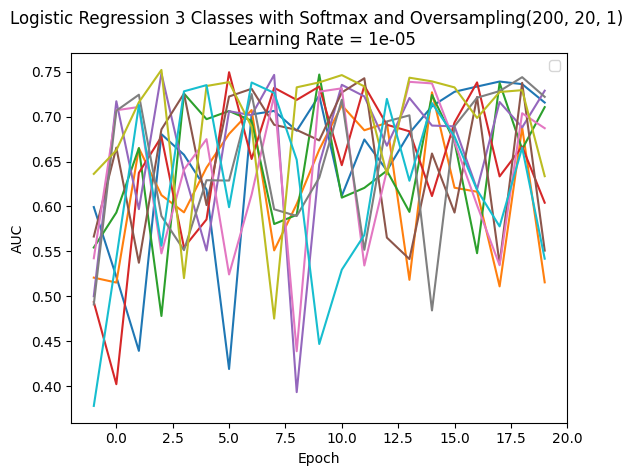


Test set: Avg. loss: 0.035017181396484375, AUC: 0.44364800000000004


Test set: Avg. loss: 0.015446857134501139, AUC: 0.6022645


Test set: Avg. loss: 0.01628248341878255, AUC: 0.6431470000000001


Test set: Avg. loss: 0.012092852592468261, AUC: 0.6560597499999999


Test set: Avg. loss: 0.013073909441630045, AUC: 0.6571219999999999


Test set: Avg. loss: 0.010449228922526041, AUC: 0.6511922499999999


Test set: Avg. loss: 0.011208521842956542, AUC: 0.6677722500000001


Test set: Avg. loss: 0.009488044738769531, AUC: 0.6687525


Test set: Avg. loss: 0.011385745366414388, AUC: 0.67161425


Test set: Avg. loss: 0.013836042722066243, AUC: 0.6723500000000001


Test set: Avg. loss: 0.009395045280456543, AUC: 0.6728160000000001


Test set: Avg. loss: 0.00960249392191569, AUC: 0.667486


Test set: Avg. loss: 0.010302994092305501, AUC: 0.67432825


Test set: Avg. loss: 0.010255601247151693, AUC: 0.6807749999999999


Test set: Avg. loss: 0.00937665843963623, AUC: 0.684497


Test set: Avg. loss:


Test set: Avg. loss: 0.010631013870239257, AUC: 0.6450755


Test set: Avg. loss: 0.021394105275472006, AUC: 0.656566


Test set: Avg. loss: 0.012369516054789226, AUC: 0.678347


Test set: Avg. loss: 0.011878376960754394, AUC: 0.67888825


Test set: Avg. loss: 0.011204333305358886, AUC: 0.6851815


Test set: Avg. loss: 0.009571318944295247, AUC: 0.6836899999999999


Test set: Avg. loss: 0.010561266581217447, AUC: 0.6866945000000001


Test set: Avg. loss: 0.011013035456339517, AUC: 0.6907405


Test set: Avg. loss: 0.008333815733591715, AUC: 0.6896570000000001


Test set: Avg. loss: 0.008625416278839112, AUC: 0.6908855


Test set: Avg. loss: 0.008880722363789876, AUC: 0.68497


Test set: Avg. loss: 0.008283865133921306, AUC: 0.69303675


Test set: Avg. loss: 0.007537400563557943, AUC: 0.68257925


Test set: Avg. loss: 0.00829207690556844, AUC: 0.7025237500000001


Test set: Avg. loss: 0.008033687591552735, AUC: 0.6923005


Test set: Avg. loss: 0.006909210364023845, AUC: 0.696774999999999

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.009524466514587403, AUC: 0.6783845


Test set: Avg. loss: 0.01038146209716797, AUC: 0.6738685000000001



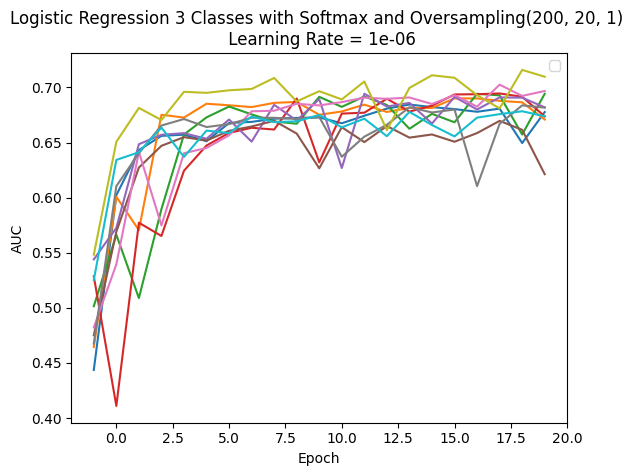


Test set: Avg. loss: 0.052381303151448566, AUC: 0.39265


Test set: Avg. loss: 0.015721320152282715, AUC: 0.58274525


Test set: Avg. loss: 0.01848768933614095, AUC: 0.569862


Test set: Avg. loss: 0.01342684523264567, AUC: 0.6359942500000001


Test set: Avg. loss: 0.016694340070088704, AUC: 0.6225900000000001


Test set: Avg. loss: 0.011533354759216309, AUC: 0.6384355


Test set: Avg. loss: 0.01303922971089681, AUC: 0.6325832499999999


Test set: Avg. loss: 0.012588943163553874, AUC: 0.6466860000000001


Test set: Avg. loss: 0.01185831101735433, AUC: 0.65275975


Test set: Avg. loss: 0.012444459279378255, AUC: 0.6504145


Test set: Avg. loss: 0.012022749900817871, AUC: 0.6651637499999999


Test set: Avg. loss: 0.01070751126607259, AUC: 0.6745492500000001


Test set: Avg. loss: 0.011237629890441895, AUC: 0.664382


Test set: Avg. loss: 0.010614889144897461, AUC: 0.66060425


Test set: Avg. loss: 0.009675598780314128, AUC: 0.6706425


Test set: Avg. loss: 0.010007202466328939, AUC: 0.6


Test set: Avg. loss: 0.01827287228902181, AUC: 0.6123162499999999


Test set: Avg. loss: 0.016687814712524413, AUC: 0.6111305


Test set: Avg. loss: 0.014803380648295084, AUC: 0.63970725


Test set: Avg. loss: 0.013842148780822754, AUC: 0.6562595


Test set: Avg. loss: 0.014509323120117188, AUC: 0.65467


Test set: Avg. loss: 0.013953164418538411, AUC: 0.6596022500000001


Test set: Avg. loss: 0.013376644770304362, AUC: 0.6715062500000001


Test set: Avg. loss: 0.013120632489522298, AUC: 0.67474775


Test set: Avg. loss: 0.013873780568440755, AUC: 0.6792594999999999


Test set: Avg. loss: 0.01398149840037028, AUC: 0.676605


Test set: Avg. loss: 0.011389257113138835, AUC: 0.67104825


Test set: Avg. loss: 0.012736190478006998, AUC: 0.6749172500000001


Test set: Avg. loss: 0.012316843350728354, AUC: 0.6750145


Test set: Avg. loss: 0.012781028747558593, AUC: 0.6755605


Test set: Avg. loss: 0.010823393821716308, AUC: 0.673929


Test set: Avg. loss: 0.010391881624857584, AUC: 0.6527737

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.009571019808451335, AUC: 0.6585850000000001


Test set: Avg. loss: 0.008543197631835937, AUC: 0.656798



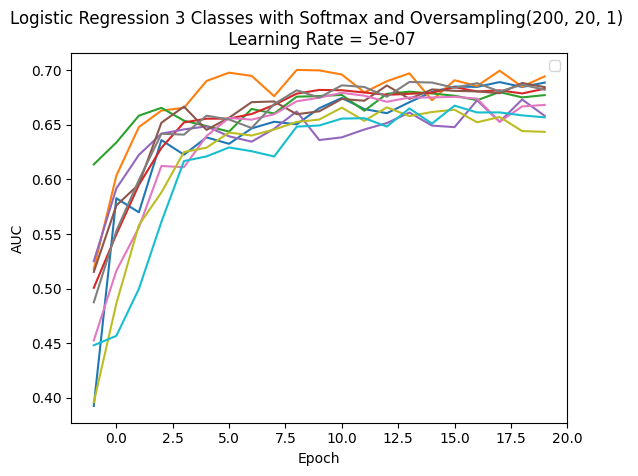


Test set: Avg. loss: 0.13949103291829426, AUC: 0.4334805


Test set: Avg. loss: 0.02897759691874186, AUC: 0.464387


Test set: Avg. loss: 0.026739939371744792, AUC: 0.4691505


Test set: Avg. loss: 0.02634507624308268, AUC: 0.47729350000000004


Test set: Avg. loss: 0.023800334294637043, AUC: 0.50794175


Test set: Avg. loss: 0.023175184885660807, AUC: 0.537193


Test set: Avg. loss: 0.022624548594156902, AUC: 0.5470555


Test set: Avg. loss: 0.021011419932047526, AUC: 0.5504527499999999


Test set: Avg. loss: 0.020405422846476236, AUC: 0.571943


Test set: Avg. loss: 0.020875965118408203, AUC: 0.5712775


Test set: Avg. loss: 0.01941298548380534, AUC: 0.5824605


Test set: Avg. loss: 0.019311667760213216, AUC: 0.5854314999999999


Test set: Avg. loss: 0.019226905822753906, AUC: 0.592241


Test set: Avg. loss: 0.01807918866475423, AUC: 0.5960427500000001


Test set: Avg. loss: 0.01821380106608073, AUC: 0.6036127499999999


Test set: Avg. loss: 0.0181533571879069, AUC: 0.60329824999999


Test set: Avg. loss: 0.017228277206420898, AUC: 0.5483975


Test set: Avg. loss: 0.01744198735555013, AUC: 0.5587425


Test set: Avg. loss: 0.016289145787556965, AUC: 0.5735995


Test set: Avg. loss: 0.01557915751139323, AUC: 0.57077775


Test set: Avg. loss: 0.015861126263936362, AUC: 0.57983325


Test set: Avg. loss: 0.014773370107014974, AUC: 0.58555625


Test set: Avg. loss: 0.014433507283528647, AUC: 0.6045145000000001


Test set: Avg. loss: 0.01541829522450765, AUC: 0.57466075


Test set: Avg. loss: 0.015887566884358724, AUC: 0.5815895


Test set: Avg. loss: 0.014177151679992676, AUC: 0.6049027499999999


Test set: Avg. loss: 0.014901875178019205, AUC: 0.59870125


Test set: Avg. loss: 0.013895503679911296, AUC: 0.6113745


Test set: Avg. loss: 0.014274830182393393, AUC: 0.598275


Test set: Avg. loss: 0.01394520346323649, AUC: 0.6095325


Test set: Avg. loss: 0.014006106694539389, AUC: 0.612953


Test set: Avg. loss: 0.043606143951416015, AUC: 0.5180642499999999


Test set: Avg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.013776031176249186, AUC: 0.6196165



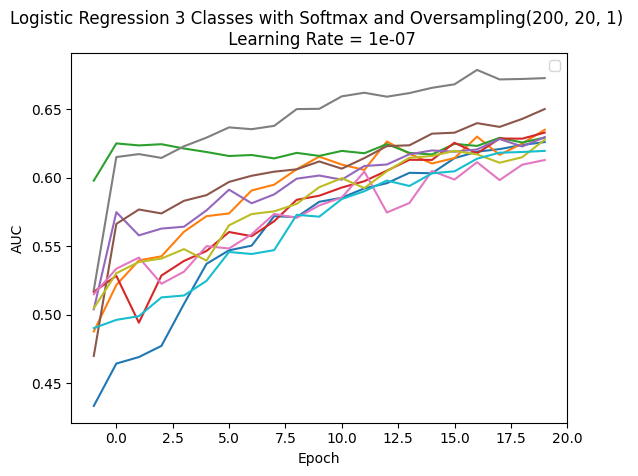


Test set: Avg. loss: 0.03811436589558919, AUC: 0.49388425


Test set: Avg. loss: 0.026274831771850585, AUC: 0.4811345


Test set: Avg. loss: 0.02131274159749349, AUC: 0.47032825000000006


Test set: Avg. loss: 0.02076095263163249, AUC: 0.47688775


Test set: Avg. loss: 0.021522842407226562, AUC: 0.480655


Test set: Avg. loss: 0.0224034735361735, AUC: 0.48156875


Test set: Avg. loss: 0.023037687301635742, AUC: 0.4795515


Test set: Avg. loss: 0.02326959228515625, AUC: 0.47975


Test set: Avg. loss: 0.023346487045288085, AUC: 0.473889


Test set: Avg. loss: 0.02318257967631022, AUC: 0.479983


Test set: Avg. loss: 0.023092225392659507, AUC: 0.478069


Test set: Avg. loss: 0.022929723103841147, AUC: 0.478041


Test set: Avg. loss: 0.02294141642252604, AUC: 0.47834325


Test set: Avg. loss: 0.02258550771077474, AUC: 0.48119275


Test set: Avg. loss: 0.02251601282755534, AUC: 0.4825025


Test set: Avg. loss: 0.022247132619222006, AUC: 0.4764665


Test set: Avg. loss: 0.022089922587076823


Test set: Avg. loss: 0.029699261983235678, AUC: 0.48420300000000005


Test set: Avg. loss: 0.030125774383544923, AUC: 0.47623750000000004


Test set: Avg. loss: 0.030249359766642253, AUC: 0.47295449999999994


Test set: Avg. loss: 0.0302638308207194, AUC: 0.4768305


Test set: Avg. loss: 0.030283419926961264, AUC: 0.47816099999999995


Test set: Avg. loss: 0.0302611141204834, AUC: 0.48240099999999997


Test set: Avg. loss: 0.03041232617696126, AUC: 0.47377775000000005


Test set: Avg. loss: 0.030567861557006835, AUC: 0.474274


Test set: Avg. loss: 0.030167404810587564, AUC: 0.476694


Test set: Avg. loss: 0.030085437138875324, AUC: 0.47807599999999995


Test set: Avg. loss: 0.02983072026570638, AUC: 0.47892625


Test set: Avg. loss: 0.029730171203613282, AUC: 0.4826125


Test set: Avg. loss: 0.029270572662353514, AUC: 0.4839995


Test set: Avg. loss: 0.029288262049357097, AUC: 0.483746


Test set: Avg. loss: 0.02907855224609375, AUC: 0.48258274999999995


Test set: Avg. loss: 0.12003

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.026845144271850585, AUC: 0.6043715000000001



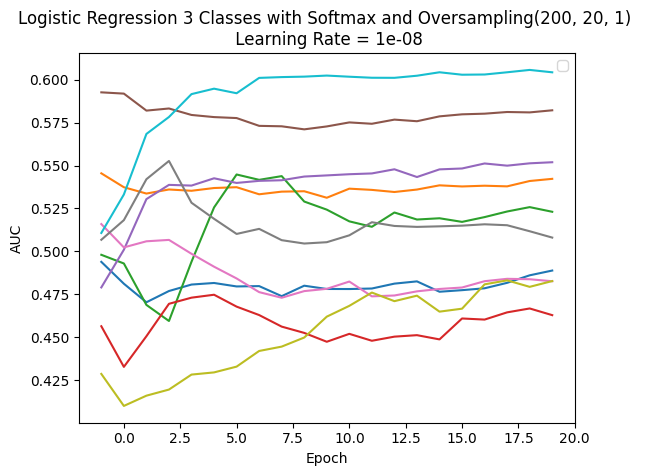


Test set: Avg. loss: 0.017977181752522785, AUC: 0.47609


Test set: Avg. loss: 0.017288987477620442, AUC: 0.47926799999999997


Test set: Avg. loss: 0.016707068125406902, AUC: 0.47944624999999996


Test set: Avg. loss: 0.016219896316528322, AUC: 0.48849


Test set: Avg. loss: 0.015821300188700357, AUC: 0.4940709999999999


Test set: Avg. loss: 0.015520045598347982, AUC: 0.498302


Test set: Avg. loss: 0.015282290776570638, AUC: 0.503911


Test set: Avg. loss: 0.015127231280008951, AUC: 0.5063049999999999


Test set: Avg. loss: 0.015036039034525554, AUC: 0.508796


Test set: Avg. loss: 0.01501088809967041, AUC: 0.5174074999999999


Test set: Avg. loss: 0.015047601699829102, AUC: 0.5213215


Test set: Avg. loss: 0.015125670750935872, AUC: 0.52623975


Test set: Avg. loss: 0.015247559229532878, AUC: 0.532787


Test set: Avg. loss: 0.015402951876322428, AUC: 0.5357015


Test set: Avg. loss: 0.015582045237223308, AUC: 0.53724875


Test set: Avg. loss: 0.015787187894185383, AUC: 0.5430545




Test set: Avg. loss: 0.06337646230061848, AUC: 0.4578495


Test set: Avg. loss: 0.06069658406575521, AUC: 0.4585005


Test set: Avg. loss: 0.05817506917317709, AUC: 0.46111425


Test set: Avg. loss: 0.055829764048258464, AUC: 0.4601615


Test set: Avg. loss: 0.053771703084309896, AUC: 0.46176375


Test set: Avg. loss: 0.05174275334676107, AUC: 0.459219


Test set: Avg. loss: 0.04996565373738607, AUC: 0.46065150000000005


Test set: Avg. loss: 0.04829325612386068, AUC: 0.465952


Test set: Avg. loss: 0.04676247914632162, AUC: 0.4682465


Test set: Avg. loss: 0.04528719965616862, AUC: 0.4716047500000001


Test set: Avg. loss: 0.04383530044555664, AUC: 0.4790535


Test set: Avg. loss: 0.042484219868977866, AUC: 0.48312924999999995


Test set: Avg. loss: 0.041197362263997395, AUC: 0.48391700000000004


Test set: Avg. loss: 0.040095152537027993, AUC: 0.48525175000000004


Test set: Avg. loss: 0.015372868220011392, AUC: 0.4751255


Test set: Avg. loss: 0.015317173322041829, AUC: 0.482135000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.014892524083455403, AUC: 0.576527



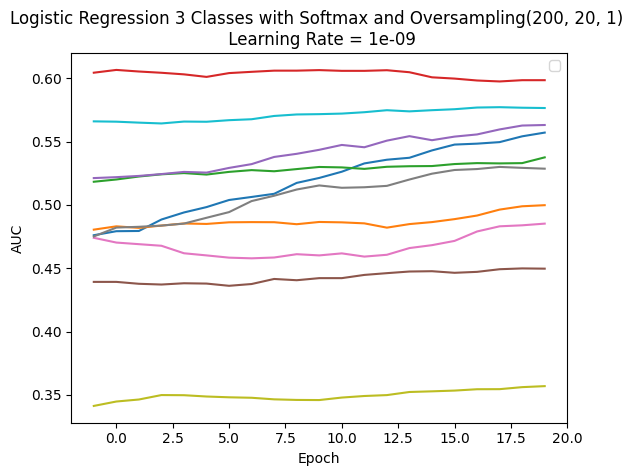

In [28]:
# SOFTMAX 3 class oversampled 

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8, 1e-9]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(3, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/reduced{i}/model{epoch}"
            directory=None
            _, _ = train.train_softmax(epoch, train_loader_oversampled, network, optimizer, verbose=False, directory=directory)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 3 Classes with Softmax and Oversampling" + str(ratio) + " \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()


Test set: Avg. loss: 0.027278324127197266, AUC: 0.5017555


Test set: Avg. loss: 0.13381845092773437, AUC: 0.561756


Test set: Avg. loss: 0.47397650146484377, AUC: 0.60756375


Test set: Avg. loss: 0.031903024037679036, AUC: 0.73707175


Test set: Avg. loss: 0.09007032521565755, AUC: 0.6204689999999999


Test set: Avg. loss: 0.07578592681884766, AUC: 0.6832007500000001


Test set: Avg. loss: 0.11530657958984375, AUC: 0.5808265


Test set: Avg. loss: 0.05726243336995443, AUC: 0.59841225


Test set: Avg. loss: 0.25517901611328125, AUC: 0.41748874999999996


Test set: Avg. loss: 0.03171656608581543, AUC: 0.71762025


Test set: Avg. loss: 0.13086146036783855, AUC: 0.51585325


Test set: Avg. loss: 0.05673353830973307, AUC: 0.715285


Test set: Avg. loss: 0.04710827000935872, AUC: 0.693043


Test set: Avg. loss: 0.05496804682413737, AUC: 0.6913012500000001


Test set: Avg. loss: 0.11912290445963541, AUC: 0.5764587499999999


Test set: Avg. loss: 0.059722113291422525, AUC: 0.6874105


Test


Test set: Avg. loss: 0.04923119862874349, AUC: 0.712338


Test set: Avg. loss: 0.0528230349222819, AUC: 0.6734385


Test set: Avg. loss: 0.08442920430501302, AUC: 0.701824


Test set: Avg. loss: 0.03357602945963541, AUC: 0.707957


Test set: Avg. loss: 0.0514957275390625, AUC: 0.6983282499999999


Test set: Avg. loss: 0.26874932861328127, AUC: 0.700715


Test set: Avg. loss: 0.08165846761067708, AUC: 0.56530625


Test set: Avg. loss: 0.04067917505900065, AUC: 0.696275


Test set: Avg. loss: 0.04190600331624349, AUC: 0.72414925


Test set: Avg. loss: 0.03577726109822591, AUC: 0.7156724999999999


Test set: Avg. loss: 0.03505970128377279, AUC: 0.6903815


Test set: Avg. loss: 0.13273321024576823, AUC: 0.57072125


Test set: Avg. loss: 0.07165538533528645, AUC: 0.579363


Test set: Avg. loss: 0.03927540588378906, AUC: 0.71779325


Test set: Avg. loss: 0.033776905059814455, AUC: 0.470548


Test set: Avg. loss: 0.06059417597452799, AUC: 0.654


Test set: Avg. loss: 0.0408500493367513, AUC:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.052827313741048175, AUC: 0.7015239999999999



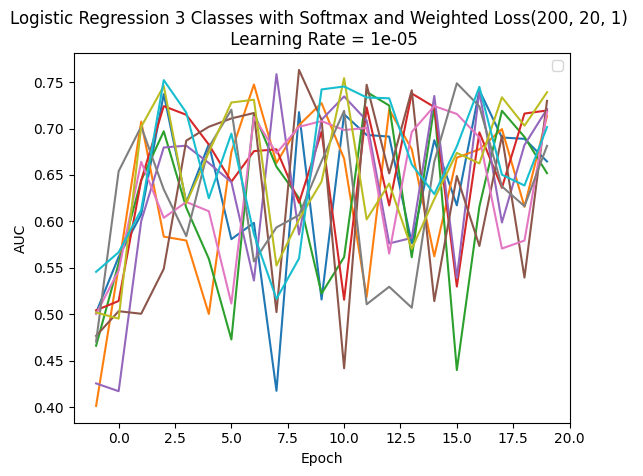


Test set: Avg. loss: 0.041386871337890624, AUC: 0.5685355


Test set: Avg. loss: 0.024915112177530924, AUC: 0.6321215


Test set: Avg. loss: 0.01232682450612386, AUC: 0.6448535


Test set: Avg. loss: 0.012196064631144206, AUC: 0.6700025000000001


Test set: Avg. loss: 0.011559058507283528, AUC: 0.6840595


Test set: Avg. loss: 0.012374046007792155, AUC: 0.67644625


Test set: Avg. loss: 0.015604962031046549, AUC: 0.6355357500000001


Test set: Avg. loss: 0.014493640899658202, AUC: 0.68314375


Test set: Avg. loss: 0.022033427556355793, AUC: 0.649032


Test set: Avg. loss: 0.014532573699951172, AUC: 0.6599937499999999


Test set: Avg. loss: 0.013509108861287434, AUC: 0.655014


Test set: Avg. loss: 0.011499571482340494, AUC: 0.67204


Test set: Avg. loss: 0.01767531967163086, AUC: 0.6619405


Test set: Avg. loss: 0.0077391438484191895, AUC: 0.662064


Test set: Avg. loss: 0.013694443702697755, AUC: 0.6658314999999999


Test set: Avg. loss: 0.018237394332885744, AUC: 0.6386425


Test se


Test set: Avg. loss: 0.01902125930786133, AUC: 0.60196275


Test set: Avg. loss: 0.017328930536905925, AUC: 0.61863725


Test set: Avg. loss: 0.017338473002115884, AUC: 0.652112


Test set: Avg. loss: 0.008893470446268717, AUC: 0.6717707500000001


Test set: Avg. loss: 0.0087307554880778, AUC: 0.6544665000000001


Test set: Avg. loss: 0.010024749437967936, AUC: 0.7003874999999999


Test set: Avg. loss: 0.011344739278157552, AUC: 0.69920075


Test set: Avg. loss: 0.02656643486022949, AUC: 0.6353285


Test set: Avg. loss: 0.008037208239237467, AUC: 0.63733125


Test set: Avg. loss: 0.015906424204508465, AUC: 0.623002


Test set: Avg. loss: 0.012989283561706543, AUC: 0.6719744999999999


Test set: Avg. loss: 0.010048483530680339, AUC: 0.601642


Test set: Avg. loss: 0.011017618179321289, AUC: 0.6823662500000001


Test set: Avg. loss: 0.014285988489786784, AUC: 0.67891


Test set: Avg. loss: 0.09555476633707682, AUC: 0.462124


Test set: Avg. loss: 0.06579640452067058, AUC: 0.4526565


Te

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.02695303789774577, AUC: 0.5808329999999999


Test set: Avg. loss: 0.011240044593811034, AUC: 0.65612



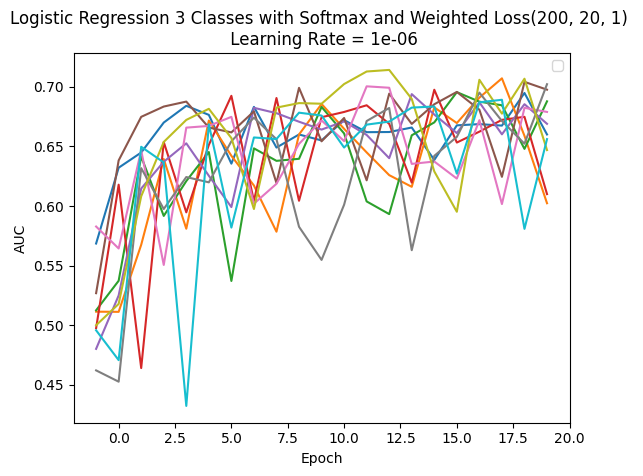


Test set: Avg. loss: 0.04323223622639974, AUC: 0.5278695


Test set: Avg. loss: 0.013756446202596029, AUC: 0.6012832499999999


Test set: Avg. loss: 0.012231678009033202, AUC: 0.6195355


Test set: Avg. loss: 0.009545288403828938, AUC: 0.6290785


Test set: Avg. loss: 0.015360271771748861, AUC: 0.58742


Test set: Avg. loss: 0.013746174812316894, AUC: 0.6407355


Test set: Avg. loss: 0.01786500549316406, AUC: 0.54551125


Test set: Avg. loss: 0.011130002657572429, AUC: 0.6548615000000001


Test set: Avg. loss: 0.009780527432759603, AUC: 0.665522


Test set: Avg. loss: 0.011161704063415528, AUC: 0.6209705


Test set: Avg. loss: 0.010175504366556804, AUC: 0.67025375


Test set: Avg. loss: 0.01271949036916097, AUC: 0.6483287499999999


Test set: Avg. loss: 0.009810564359029134, AUC: 0.676991


Test set: Avg. loss: 0.009675751368204753, AUC: 0.6782179999999999


Test set: Avg. loss: 0.008652940114339192, AUC: 0.655601


Test set: Avg. loss: 0.015811410586039226, AUC: 0.6604457499999999





Test set: Avg. loss: 0.013489747683207194, AUC: 0.6381682499999999


Test set: Avg. loss: 0.012529468218485515, AUC: 0.6526877499999999


Test set: Avg. loss: 0.010328749974568684, AUC: 0.65333775


Test set: Avg. loss: 0.013489152590433756, AUC: 0.63976275


Test set: Avg. loss: 0.015874249458312988, AUC: 0.6586639999999999


Test set: Avg. loss: 0.015872395515441895, AUC: 0.6662305


Test set: Avg. loss: 0.010571037292480469, AUC: 0.6602030000000001


Test set: Avg. loss: 0.010444599151611328, AUC: 0.67436125


Test set: Avg. loss: 0.010503928184509277, AUC: 0.6835935


Test set: Avg. loss: 0.012370331764221192, AUC: 0.68278175


Test set: Avg. loss: 0.010130077679951985, AUC: 0.6859280000000001


Test set: Avg. loss: 0.017064492543538413, AUC: 0.6758290000000001


Test set: Avg. loss: 0.009442408243815105, AUC: 0.6796274999999999


Test set: Avg. loss: 0.008688749631245931, AUC: 0.684663


Test set: Avg. loss: 0.010313430786132812, AUC: 0.6917642499999999


Test set: Avg. loss: 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.007429917176564534, AUC: 0.677134



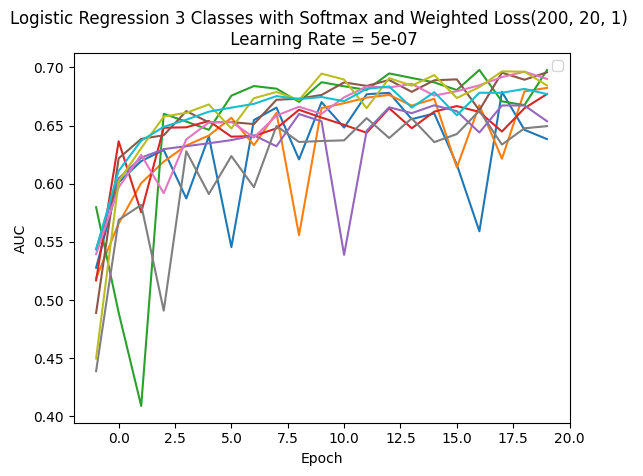


Test set: Avg. loss: 0.05538090642293294, AUC: 0.5024299999999999


Test set: Avg. loss: 0.01741732406616211, AUC: 0.6038377500000001


Test set: Avg. loss: 0.014329992294311523, AUC: 0.601232


Test set: Avg. loss: 0.015075997670491536, AUC: 0.6183479999999999


Test set: Avg. loss: 0.015743286450703938, AUC: 0.580607


Test set: Avg. loss: 0.01324752108256022, AUC: 0.6289872499999999


Test set: Avg. loss: 0.012823123613993327, AUC: 0.619846


Test set: Avg. loss: 0.014400322596232097, AUC: 0.6209705


Test set: Avg. loss: 0.014809528350830077, AUC: 0.6102709999999999


Test set: Avg. loss: 0.013863327980041504, AUC: 0.61897


Test set: Avg. loss: 0.016055488268534344, AUC: 0.6336215


Test set: Avg. loss: 0.013138948440551758, AUC: 0.6301985000000001


Test set: Avg. loss: 0.013891196250915528, AUC: 0.6339365


Test set: Avg. loss: 0.01401949405670166, AUC: 0.61966475


Test set: Avg. loss: 0.013971820513407389, AUC: 0.63475175


Test set: Avg. loss: 0.012068179766337077, AUC: 0.63


Test set: Avg. loss: 0.016858098983764648, AUC: 0.5766574999999999


Test set: Avg. loss: 0.018346330642700196, AUC: 0.56963425


Test set: Avg. loss: 0.01921599324544271, AUC: 0.5932465


Test set: Avg. loss: 0.016000096321105956, AUC: 0.5722499999999999


Test set: Avg. loss: 0.01880505116780599, AUC: 0.5900029999999999


Test set: Avg. loss: 0.01952399508158366, AUC: 0.577415


Test set: Avg. loss: 0.016658927917480467, AUC: 0.5898249999999999


Test set: Avg. loss: 0.015362918853759766, AUC: 0.5940375


Test set: Avg. loss: 0.01766305414835612, AUC: 0.6103939999999999


Test set: Avg. loss: 0.015254484494527182, AUC: 0.6149812499999999


Test set: Avg. loss: 0.014176129341125488, AUC: 0.60854675


Test set: Avg. loss: 0.016287888844807943, AUC: 0.614855


Test set: Avg. loss: 0.01646862824757894, AUC: 0.6228715


Test set: Avg. loss: 0.014078419049580891, AUC: 0.603815


Test set: Avg. loss: 0.01537700621287028, AUC: 0.6146367500000001


Test set: Avg. loss: 0.01508015791575114, A

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.01390832487742106, AUC: 0.6632365



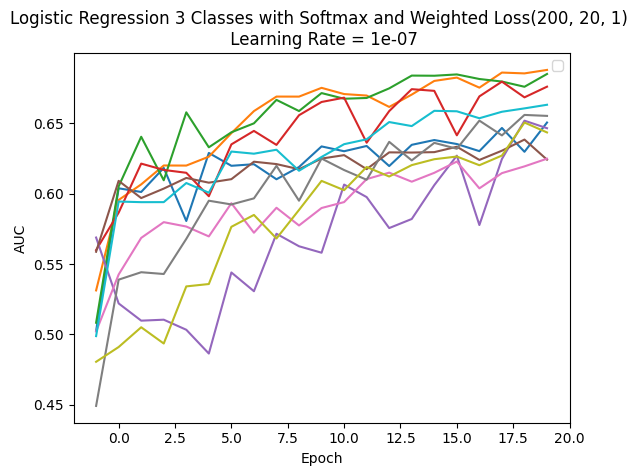


Test set: Avg. loss: 0.08208649698893229, AUC: 0.506


Test set: Avg. loss: 0.05940118535359701, AUC: 0.51623325


Test set: Avg. loss: 0.03977302169799805, AUC: 0.53706475


Test set: Avg. loss: 0.025078231811523438, AUC: 0.5633365


Test set: Avg. loss: 0.017633187611897787, AUC: 0.5611455000000001


Test set: Avg. loss: 0.015559876759847005, AUC: 0.557164


Test set: Avg. loss: 0.015241653442382812, AUC: 0.555016


Test set: Avg. loss: 0.015694823582967123, AUC: 0.558335


Test set: Avg. loss: 0.01597079626719157, AUC: 0.5597110000000001


Test set: Avg. loss: 0.01619347063700358, AUC: 0.5571065


Test set: Avg. loss: 0.01660537592569987, AUC: 0.56285675


Test set: Avg. loss: 0.017139758745829264, AUC: 0.5602677500000001


Test set: Avg. loss: 0.017261454264322917, AUC: 0.56095575


Test set: Avg. loss: 0.0172580197652181, AUC: 0.561588


Test set: Avg. loss: 0.017162933985392252, AUC: 0.560805


Test set: Avg. loss: 0.016997320810953776, AUC: 0.5577


Test set: Avg. loss: 0.01713


Test set: Avg. loss: 0.029499048868815103, AUC: 0.4453515


Test set: Avg. loss: 0.027086787541707357, AUC: 0.44611775


Test set: Avg. loss: 0.025946930567423504, AUC: 0.44871800000000006


Test set: Avg. loss: 0.02542365837097168, AUC: 0.45223900000000006


Test set: Avg. loss: 0.024782278696695963, AUC: 0.44910425000000004


Test set: Avg. loss: 0.024578390121459962, AUC: 0.45391649999999995


Test set: Avg. loss: 0.02428991953531901, AUC: 0.45425750000000004


Test set: Avg. loss: 0.02372284253438314, AUC: 0.45149025


Test set: Avg. loss: 0.023400677998860676, AUC: 0.45473274999999996


Test set: Avg. loss: 0.02289454205830892, AUC: 0.460959


Test set: Avg. loss: 0.0225400447845459, AUC: 0.4609325


Test set: Avg. loss: 0.02227574094136556, AUC: 0.45795025


Test set: Avg. loss: 0.02191727066040039, AUC: 0.4562665


Test set: Avg. loss: 0.02170407485961914, AUC: 0.45837925


Test set: Avg. loss: 0.02132782554626465, AUC: 0.4625195


Test set: Avg. loss: 0.02101655387878418, AUC:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.01737388229370117, AUC: 0.6461967500000001


Test set: Avg. loss: 0.017333240509033204, AUC: 0.6476419999999999



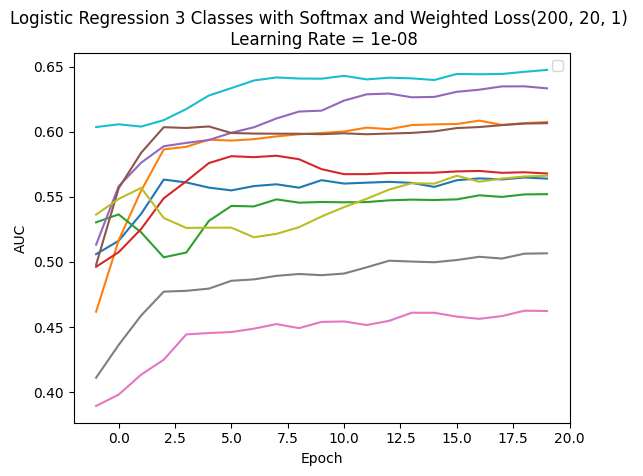


Test set: Avg. loss: 0.055658095041910806, AUC: 0.39914499999999997


Test set: Avg. loss: 0.05253292592366537, AUC: 0.39694500000000005


Test set: Avg. loss: 0.04966952387491862, AUC: 0.39578750000000007


Test set: Avg. loss: 0.04694024531046549, AUC: 0.39392699999999997


Test set: Avg. loss: 0.044639235178629555, AUC: 0.39290075


Test set: Avg. loss: 0.04243278376261393, AUC: 0.39407675


Test set: Avg. loss: 0.04050358581542969, AUC: 0.39595275


Test set: Avg. loss: 0.03876195017496745, AUC: 0.39391325


Test set: Avg. loss: 0.03726821772257487, AUC: 0.39596424999999996


Test set: Avg. loss: 0.03595787175496419, AUC: 0.400684


Test set: Avg. loss: 0.03477078247070312, AUC: 0.40181125


Test set: Avg. loss: 0.03370193354288737, AUC: 0.40102250000000006


Test set: Avg. loss: 0.03279150009155273, AUC: 0.40585525


Test set: Avg. loss: 0.03197110939025879, AUC: 0.4083927500000001


Test set: Avg. loss: 0.03125252596537272, AUC: 0.40837875


Test set: Avg. loss: 0.03055217488606


Test set: Avg. loss: 0.1141239751180013, AUC: 0.481998


Test set: Avg. loss: 0.10897882843017578, AUC: 0.47799499999999995


Test set: Avg. loss: 0.10380116017659505, AUC: 0.472744


Test set: Avg. loss: 0.09872515614827473, AUC: 0.46848600000000007


Test set: Avg. loss: 0.09366967264811198, AUC: 0.465005


Test set: Avg. loss: 0.08875055440266927, AUC: 0.461982


Test set: Avg. loss: 0.08387907155354818, AUC: 0.45845600000000003


Test set: Avg. loss: 0.07913751983642578, AUC: 0.45149924999999996


Test set: Avg. loss: 0.07450586446126302, AUC: 0.446423


Test set: Avg. loss: 0.06994730885823568, AUC: 0.4403985


Test set: Avg. loss: 0.06556364186604818, AUC: 0.43747475


Test set: Avg. loss: 0.06140389887491862, AUC: 0.4321805


Test set: Avg. loss: 0.05758224105834961, AUC: 0.42499


Test set: Avg. loss: 0.053938485463460285, AUC: 0.421376


Test set: Avg. loss: 0.050656168619791664, AUC: 0.41810675


Test set: Avg. loss: 0.047549012502034506, AUC: 0.4153312500000001


Test set: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0390203119913737, AUC: 0.4697


Test set: Avg. loss: 0.03769433720906575, AUC: 0.474924



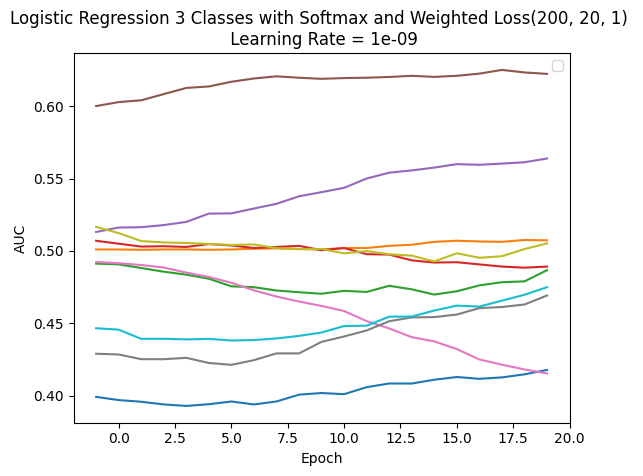

In [26]:
# SOFTMAX 3 class weighted loss

momentum=0
learning_rates = [1e-5, 1e-6, 5e-7, 1e-7, 1e-8, 1e-9]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SoftmaxLogisticRegression(3, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/reduced{i}/model{epoch}"
            directory=None
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False, directory=directory, class_weights=weight)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 3 Classes with Softmax and Weighted Loss" + str(ratio) + " \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

In [ ]:
for name, parameter in network.named_parameters(): 
    print(name)
    print(parameter)
    

In [19]:
# SIGMOID 2 CLASS RATIO

learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            directory = f"{DIRECTORY}/{str(learning_rate)}/ratio{i}_{ratio[0]}/model{epoch}"
            directory=None
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False, directory=directory)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 2 Classes " + str(ratio) + " with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   

ValueError: Target size (torch.Size([1000])) must be the same as input size (torch.Size([1000, 3]))

In [ ]:
# SIGMOID 2 CLASS RATIO w/ OVERSAMPLING 

learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_oversampled, network, optimizer, verbose=False, directory=None)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("Logistic Regression 2 Classes " + str(ratio) + " with Sigmoid and Oversampling \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

In [ ]:
# ANALYZING DATA 
experiments = [("reduced", ""), ("ratio", "_10"), ("ratio", "_100")]

means = []
stds = []

learning_rate = 5e-07
ratio_num = ratio[0]

for experiment in experiments: 
    weights = []
    biases = []
    for i in range(10): 
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        network.load_state_dict(torch.load(f"{DIRECTORY}/{learning_rate}/{experiment[0]}{i}{experiment[1]}/model19"))
        weights.append(network.state_dict()['fc.weight'])
        biases.append(network.state_dict()['fc.bias'])

    
        means.append(torch.cat(weights, 0).mean(axis=0))
        stds.append(torch.std(torch.cat(weights, 0), axis=0))

        
print(means)
print(stds)

In [ ]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 5e-7, 1e-7]
learning_rates = [5e-7]


experiments = [("reduced", ""), ("ratio", "_10"), ("ratio", "_100")]

means = []
stds = []
distances = []


for experiment in experiments: 
    for learning_rate in learning_rates: 
        best_auc = 0
        worst_auc = 100
        best_model = None
        worst_model = None 
        for i in range(10): 
            network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
            network.load_state_dict(torch.load(f"{DIRECTORY}/{learning_rate}/ratio{i}_100/model19"))
            weight = network.state_dict()['fc.weight']
            bias = network.state_dict()['fc.bias']
            params = torch.cat((weight.squeeze(), bias))


            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)

            if auc > best_auc:
                best_auc = auc
                best_model = params
            if auc < worst_auc:
                worst_auc = auc
                worst_model = params


        dist = np.linalg.norm(best_model - worst_model)
        print(dist)

In [ ]:

def cosine_similarity(model_param1, model_param2): 
     return np.dot(model_param1, model_param2)/(np.linalg.norm(model_param1, axis=0)*np.linalg.norm(model_param2)) 

def euclidean_distance(model_param1, model_param2): 
    return np.linalg.norm(model_param1 - model_param2)


def pairwise_distance(model_params, distance_fn=euclidean_distance): 
    distances = []
    for i in range(len(model_params)):
        for j in range(i + 1, len(model_params)):
            distances.append(distance_fn(model_params[i], model_params[j]))
    return distances

def distance(model_params1, model_params2, distance_fn=euclidean_distance):
    distances = []
    for i in range(len(model_params1)): 
        for j in range(len(model_params2)):
            distances.append(distance_fn(model_params1[i], model_params2[j]))
    return distances



In [ ]:
learning_rate = 1e-6
experiments = [("reduced", ""), ("ratio", "_10"), ("ratio", "_100")]

model_dict = {}

distance_fn = euclidean_distance

for experiment in experiments: 
    model_params = []
    for i in range(10): 
        network = models.SigmoidLogisticRegression(NUM_CLASSES_REDUCED, shape=32*32*3)
        network.load_state_dict(torch.load(f"{DIRECTORY}/{learning_rate}/{experiment[0]}{i}{experiment[1]}/model19"))
        model_params.append(torch.cat((network.state_dict()['fc.weight'].squeeze(), network.state_dict()['fc.bias'])))
    model_dict[experiment[0] + experiment[1]] = model_params



for model_name, model_params in model_dict.items():
    
    distances = pairwise_distance(model_params, distance_fn=distance_fn)
    
    plt.hist(distances)
    plt.title(model_name)
    plt.show()
    

distances = distance(model_dict["reduced"], model_dict["ratio_100"], distance_fn=distance_fn)
plt.hist(distances)
plt.title("reduced vs ratio_100")
plt.show()
    
distances = distance(model_dict["reduced"], model_dict["ratio_10"], distance_fn=distance_fn)
plt.hist(distances)
plt.title("reduced vs ratio_10")
plt.show()
      
